In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr,kendalltau
# import pandas as pd
from sklearn import metrics
import statsmodels.api as sm
from scipy import stats
from matplotlib import cm
import matplotlib as mpl
import datetime as dt
%matplotlib notebook

from sklearn.model_selection import KFold
from scipy.optimize import curve_fit


mpl.rcParams["mathtext.default"]='regular'
# pd.options.display.float_format = '{:+,.2f}'.format
pd.options.display.float_format = '{:.3f}'.format

Units = ['$\mu mol m^{-2}$ $s^{-1}$','nmol $m^{-2}$ $s^{-1}$','G']
Units_gd = ['g $CO_2-C$ $m^{-2}$ $d^{-1}$','mg $CH_h-C$ $m^{-2}$ $d^{-1}$','G']
cm_2_in=1/2.54
Aliases = ['NEE',
'NME','Net C Balance']

mult = {'fco2':(1e-6 * 12.0107 *3600),
        'fco2g':(1e-6 * 44.01 *3600),
        'fch4':(1e-9 * 12.0107 *3600),
        'fch4g':(1e-9 * 16.01 *3600),
        'gwp':(28e-9 * 12.0107 *3600) }

def r_pvalues(df,method='pearson',L=3):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    rvalues = dfcols.transpose().join(dfcols, how='outer')
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            if method == 'spearman':
                rvalues[r][c] = round(spearmanr(df[r], df[c])[0], L)
                pvalues[r][c] = round(spearmanr(df[r], df[c])[1], L)
            elif method == 'kendall':
                rvalues[r][c] = round(kendalltau(df[r], df[c])[0], L)
                pvalues[r][c] = round(kendalltau(df[r], df[c])[1], L)
            else:
                rvalues[r][c] = round(pearsonr(df[r], df[c])[0], L)
                pvalues[r][c] = round(pearsonr(df[r], df[c])[1], L)
    
    return rvalues,pvalues



def Q10 (T,R10,Q10):
    return(R10*Q10**(T-10/10))

def Hyperbola(PPFD,alpha,beta,gamma):
    return(alpha*beta*PPFD/(alpha*PPFD+beta)+np.abs(gamma))

def Non_RectHyperbola2(PPFD,alpha,beta,gamma):
    return (-(beta+gamma)*(1-np.exp(-alpha*PPFD/(beta+gamma)))+gamma)

def Non_RectHyperbola(PPFD,alpha,beta,theta,gamma):
    return (1/(2*theta)*(alpha*PPFD+beta - ((alpha*PPFD+beta)**2-4*alpha*beta*theta*PPFD)**.5)+gamma)

def KFC(X,y,AllData,Pred_Data,Alt_X,curve,K=30,random_state=1,Verbose = True,CI=False,Guess=None):
    Data = AllData[X+y].dropna()
#     Data = AllData[X+y].dropna()

    kf = KFold(n_splits=K,shuffle=True, random_state = random_state)
    R2 = []
    MSE = []
    Int = []
    Coef = []
    Pred = []
    for train_index, test_index in kf.split(Data):
        df_test = Data.iloc[test_index]
        df_train = Data.iloc[train_index]
        X_train = np.array(df_train[X])#.reshape(-1, 1)     
        y_train = np.array(df_train[y]).flatten()#(-1, 1)
        X_test = np.array(df_test[X])#.reshape(-1, 1)  
        y_test = np.array(df_test[y]).flatten()#(-1, 1)
        if X_train.shape[1]==1:
            X_train = X_train.flatten()
            X_test = X_test.flatten()
        if Guess == None:
            popt, pcov = curve_fit(curve, X_train,y_train)
        else:
            popt, pcov = curve_fit(curve, X_train,y_train,Guess)
            
        Test = curve(X_test, *popt)
#         print(popt)
        R2.append(metrics.r2_score(y_test,Test))
        MSE.append(metrics.mean_squared_error(y_test,Test))
        Pred.append(curve(Pred_Data[Alt_X].values, *popt))
        Coef.append([*popt])
    Coef_min = np.nanmin(np.array(Coef),axis=0)
    Coef_max = np.nanmax(np.array(Coef),axis=0)
    Coef_std = np.nanstd(np.array(Coef),axis=0)
    Coef = np.nanmean(np.array(Coef),axis=0)
    if Verbose == True:
        print()
        print(Data.shape)
        print(y[0])
        print('RMSE', np.round(np.mean(np.array(MSE)**.5),5))
        print('std RMSE', np.round(np.std(np.array(MSE)**.5),5))
        print('r2', np.round(np.median(np.array(R2)),5))
        print('Coef', Coef)
        print('Coef_CI', (Coef_std/K**.5)*stats.t.ppf(0.975,K))
        for a,k in zip(Coef,['a','b','c','d']):
            print(k,' {:4f}'.format(a))
    if CI == True:
#     return(np.mean(np.array(Pred),axis=0))
        return(np.mean(np.array(Pred),axis=0),
               (np.std(np.array(Pred),axis=0)/(K**.5))*stats.t.ppf(0.975,K),Coef)
    else:
        return(np.nanmean(np.array(Pred),axis=0))
    

GS_Start = 161
GS_End = 256

ER_U_bound = 3.71 # All
ER_U_bound = 9# 5.98 # June/July

G_Drive = 'C:\\Users\\User\\Google Drive\\'

In [9]:
# T = Data.loc[Data['fco2'].isnull()==False].resample('D').min()[['PPFD_Avg','Active_Layer_1']].copy()

# plt.ylim(0,50)
# print(Data.loc[((Data['fco2'].isnull()==False)&(Data.Daytime==0))].index)

In [377]:

# Dpath = G_Drive+'FishIsland_Outputs/Upscaled_Estimates_Q10_Final.csv'
Dpath = G_Drive+'FishIsland_Outputs/Upscaled_Estimates_Q10_5cm_Mean_Night.csv'
# Dpath = G_Drive+'FishIsland_Outputs/Upscaled_Estimates_ER_GS_Season_Fixed.csv'
Dpath = G_Drive+'FishIsland_Outputs/Upscaled_Estimates_ER_2Method_Mean.csv'
# Dpath = G_Drive+'FishIsland_Outputs/Upscaled_Estimates_VPD_Final.csv'
#
Data = pd.read_csv(Dpath,index_col=['datetime'],parse_dates=['datetime'])
Data = Data.drop(columns=['datetime.1'])
# Data[['fch4','FCH4_FP']].describe()

Dpath = G_Drive+'FishIsland_Outputs/Benchmark_1h.csv'
Benchmark_h = pd.read_csv(Dpath,index_col=['datetime'],parse_dates=['datetime'])

Benchmark_h = Benchmark_h.rename(columns={
'NEE_est':'NEE_benchmark',
'NME_est':'NME_benchmark',
'NEE_est_CI':'NEE_benchmark_CI',
'NME_est_CI':'NME_benchmark_CI'
})

Benchmark_h.index = Benchmark_h.index.tz_localize(None)
Data=Data.join(Benchmark_h[['NEE_benchmark','NEE_benchmark_CI','NME_benchmark','NME_benchmark_CI']])
Data['NDWI_FI_LCP']=Data['NDWI_FI_LCP'].interpolate()
Data['NDSI_FI_LCP']=Data['NDSI_FI_LCP'].interpolate()

Data['Study_Year']=np.nan
Data.loc[((Data.index.year>=2009)&(Data.index.year<=2019)),'Study_Year'] = 1
Data['Study_Year']*=Data['Study_Season']

SF = Data.loc[(Data.index.month>=9)&(Data['snow_cover']>=18.75)].resample('Y').first()[['DOY']]
for i,d in SF.iterrows():
    Data.loc[((Data.index.year==i.year)&(Data['DOY']>=d.values[0])),'Study_Year']=np.nan
    Data.loc[((Data.index.year==i.year)&(Data['DOY']>=d.values[0])),'Study_Season']=np.nan

Data['Date'] = Data.index.date
GPP = pd.read_csv(G_Drive+'earthengine/GPP_FishIsland.csv',parse_dates=['date'],
                  na_values=-9999,index_col=['date']).dropna()
GPP=GPP.drop(['.geo','system:index'],axis=1)

GPP = GPP.rename(columns={'GPP_FI':'GPP_8d',
                          'PsnNet_FI':'PSN_8d'})

GPP[['GPP_8d','PSN_8d']]*=0.0001*1e3
GPP['DOY']=GPP.index.dayofyear
Slice = GPP.loc[GPP['DOY'].diff(1)==16].copy()
Slice.index = Slice.index-dt.timedelta(hours=(24*8))
Slice['GPP_8d']=-9999
GPP = GPP.append(Slice)
GPP = GPP.drop('DOY',axis=1)
GPP = GPP.sort_index()

try:
    Data=Data.drop('GPP_8d',axis=1)
except:
    pass

Data = Data.join(GPP)
Data['GPP_d'] = Data['GPP_8d'].interpolate()/8/24
Data['PSN_d'] = Data['PSN_8d'].interpolate()/8/24
Data['GPPK'] = Data.reset_index().index
Data['GPPK'] *= (Data['GPP_8d']*0+1)
Data['GPPK'] = Data['GPPK'].ffill()
Data['GPPK_DOY'] = Data['GPP_8d'].index.dayofyear.copy()
Data['GPPK_DOY'] *= (Data['GPP_8d']*0+1)
Data['GPPK_DOY'] = Data['GPPK_DOY'].ffill()
Data.loc[Data['GPP_8d']<0]=np.nan

for y in range(2000,2021):
    sub = Data.loc[Data.index.year==y].copy()
    sub['GPPK2'] = sub.reset_index().index
    sub['GPPK2'] *= (sub['GPP_8d']*0+1)
    sub['GPPK2'] = sub['GPPK2'].ffill()*sub['Study_Year']
    Data.loc[Data.index.year==y,'GPPK2'] = sub['GPPK2'].copy()

F = 'fco2'
Temp = Data.loc[((Data['Daytime']==0)|
                 (Data['PPFD_Avg']<10)),
                [F,'Temp_5_1','Temp_15_1','Temp_5_2','Air_Temp','PPFD_Avg','ER_est','NEE_est']].dropna()

T_x = 'Temp_5_1'
y = [F]
X = [T_x]
Alt_X=[T_x]
ER,CI,Coef = KFC(X,y,Temp,Data,Alt_X,Q10,K=10,CI=True,Verbose=True)

Data['ER_Q10']=ER
Data['ER_Q10_CI']=CI

Data['GPP_Q10'] = Data['ER_Q10'] - Data['NEE_est']
Data['GPP_Q10_CI'] = Data['ER_Q10_CI'] + Data['NEE_est_CI']

Data.loc[Data['Daytime']==0,'GPP_Q10']=0
Data.loc[Data['Daytime']==0,'GPP_Q10_CI']=0

print(Data.loc[((Data['GPP_Q10']<0)&(Data['Study_Season']==1)),'GPP_Q10'].describe())

Data.loc[Data['GPP_Q10']<0,'GPP_Q10']=0
Data.loc[Data['GPP_Q10']<0,'GPP_Q10_CI']=0
    
y = ['fco2']
X = ['PPFD_Avg']
Alt_X = ['PPFD_Avg']
#rect
Guess = [0.00033,0.66,0.019]
#nonRect
Guess = [0.00026,0.29,0.98,0.016]
#nonRect2
Guess = [0.00033,0.39,0.02]

for v in Data['GPPK_DOY'].unique():
    Temp = Data.loc[((Data['Daytime']==1)&(Data['GPPK_DOY']==v)),
            ['GPP_Q10','PPFD_Avg','ER_Q10','fco2','NEE_est']].dropna()
    if Temp.shape[0]>0:
#         print(Temp.shape)
        GPP,CI,Coef = KFC(X,y,Temp,Data,Alt_X,Non_RectHyperbola2,K=5,Verbose=False,CI=True,Guess = Guess)#
        Data['Temp'] = -GPP
        Data['CI'] = CI
    #     print(Data.loc[Data.index.dayofyear<d,'Temp'].min())
        Data.loc[((Data['Daytime']==1)&(Data['GPPK_DOY']==v)),
                 'GPP_Hyperbola']=Data.loc[((Data['Daytime']==1)&(Data['GPPK_DOY']==v)),'Temp']-Data.loc[((Data['Daytime']==1)&(Data['GPPK_DOY']==v)),'Temp'].min()
        Data.loc[((Data['Daytime']==1)&(Data['GPPK_DOY']==v)),
                 'GPP_Hyperbola_CI']=Data.loc[((Data['Daytime']==1)&(Data['GPPK_DOY']==v)),'CI']
        Data.loc[((Data['Daytime']==1)&(Data['GPPK_DOY']==v)),
                 'ER_Hyperbola']=Data.loc[((Data['Daytime']==1)&(Data['GPPK_DOY']==v)),'Temp'].min()
        
        
Data['RE_Max'] = Data[['NEE_est']].resample('D').max().resample('60T').interpolate()
Data['RE_Max_CI'] = Data['NEE_est_CI'].copy()

Data['GPP_RE_Max'] = Data['RE_Max']-Data['NEE_est']
Data['GPP_RE_Max_CI'] = Data['NEE_est_CI'].copy()
Data.loc[Data['Daytime']==0,['GPP_RE_Max','GPP_RE_Max_CI']]=0

        
Data['GPP_est'] = Data['ER_est']-Data['NEE_est']
Data['GPP_est_CI'] = Data['ER_est_CI']+Data['NEE_est_CI']
Data.loc[Data['Daytime']==0,['GPP_est','GPP_est_CI']]=0
# Data.loc[Data['GPP_est']<=0,'GPP_est']=0

Data['GPP_AL_Fix_est'] = Data['ER_AL_Fix_est']-Data['NEE_est']
Data['GPP_AL_Fix_est_CI'] = Data['ER_AL_Fix_est_CI']+Data['NEE_est_CI']
Data.loc[Data['Daytime']==0,['GPP_AL_Fix_est','GPP_AL_Fix_est_CI']]=0
# Data.loc[Data['GPP_AL_Fix_est']<=0,'GPP_AL_Fix_est']=0

# Data['GPP_AL_TS_Fix_est'] = Data['ER_AL_TS_Fix_est']-Data['NEE_est']
# Data['GPP_AL_TS_Fix_est_CI'] = Data['ER_AL_TS_Fix_est_CI']+Data['NEE_est_CI']
# Data.loc[Data['Daytime']==0,['GPP_AL_TS_Fix_est','GPP_AL_TS_Fix_est_CI']]=0

# Data['GPP_Q10_Both_est'] = Data['ER_Q10_Both_est']-Data['NEE_est']
# Data['GPP_Q10_Both_est_CI'] = Data['ER_Q10_Both_est_CI']+Data['NEE_est_CI']
# Data.loc[Data['Daytime']==0,['GPP_Q10_Both_est','GPP_Q10_Both_est_CI']]=0
# # Data.loc[Data['GPP_Q10_Both_est']<=0,'GPP_Q10_Both_est']=0


Data['NEE_est_c'] = Data['NEE_est']*mult['fco2']
Data['NEE_est_c_CI'] = Data['NEE_est_CI']*mult['fco2']
Data['ER_est_c'] = Data['ER_est']*mult['fco2']
Data['ER_est_c_CI'] = Data['ER_est_CI']*mult['fco2']
Data['ER_AL_Fix_est_c'] = Data['ER_AL_Fix_est']*mult['fco2']
Data['ER_AL_Fix_est_c_CI'] = Data['ER_AL_Fix_est_CI']*mult['fco2']
Data['RE_Max_c'] = Data['RE_Max']*mult['fco2']
Data['RE_Max_c_CI'] = Data['RE_Max_CI']*mult['fco2']
# Data['ER_AL_TS_Fix_est_c'] = Data['ER_AL_TS_Fix_est']*mult['fco2']
# Data['ER_AL_TS_Fix_est_c_CI'] = Data['ER_AL_TS_Fix_est_CI']*mult['fco2']
# Data['ER_Q10_Both_est_c'] = Data['ER_Q10_Both_est']*mult['fco2']
# Data['ER_Q10_Both_est_c_CI'] = Data['ER_Q10_Both_est_CI']*mult['fco2']



Data['ER_Hyperbola_c'] = Data['ER_Hyperbola']*mult['fco2']
Data['GPP_est_c'] = Data['GPP_est']*mult['fco2']
Data['GPP_est_c_CI'] = Data['GPP_est_CI']*mult['fco2']
Data['GPP_AL_Fix_est_c'] = Data['GPP_AL_Fix_est']*mult['fco2']
Data['GPP_AL_Fix_est_c_CI'] = Data['GPP_AL_Fix_est_CI']*mult['fco2']
Data['GPP_RE_Max_c'] = Data['GPP_RE_Max']*mult['fco2']
Data['GPP_RE_Max_c_CI'] = Data['GPP_RE_Max_CI']*mult['fco2']
# Data['GPP_AL_TS_Fix_est_c'] = Data['GPP_AL_TS_Fix_est']*mult['fco2']
# Data['GPP_AL_TS_Fix_est_c_CI'] = Data['GPP_AL_TS_Fix_est_CI']*mult['fco2']
# Data['GPP_Q10_Both_est_c'] = Data['GPP_Q10_Both_est']*mult['fco2']
# Data['GPP_Q10_Both_est_c_CI'] = Data['GPP_Q10_Both_est_CI']*mult['fco2']
Data['ER_Q10_c'] = Data['ER_Q10']*mult['fco2']
Data['ER_Q10_c_CI'] = Data['ER_Q10_CI']*mult['fco2']
Data['GPP_Q10_c'] = Data['GPP_Q10']*mult['fco2']
Data['GPP_Q10_c_CI'] = Data['GPP_Q10_CI']*mult['fco2']
Data['GPP_Hyperbola_c'] = Data['GPP_Hyperbola']*mult['fco2']
Data['GPP_Hyperbola_c_CI'] = Data['GPP_Hyperbola_CI']*mult['fco2']
Data['NME_est_c'] = Data['NME_est']*mult['fch4']
Data['NME_est_c_CI'] = Data['NME_est_CI']*mult['fch4']
Data['C']=(Data['NEE_est_c']+Data['NME_est_c'])*Data['Study_Year']
Data['C_CI']=(Data['NEE_est_c_CI']+Data['NME_est_c_CI'])*Data['Study_Year']

for F in ['NEE_est','NEE_est_c','NME_est','NME_est_c','C','ER_est_c','GPP_est_c']:
    Data[F+'_U'] = Data[F]+Data[F+'_CI']
    Data[F+'_L'] = Data[F]-Data[F+'_CI']

    
FDTS = ['PPFD_Avg','NR_Wm2_Avg','VPD','wind_speed','u*',
        'Temp_5_1','Temp_5_2','Temp_15_1','Temp_15_2','Table_1',
        'Active_Layer_1']
Flux = ['NEE_est','NEE_est_CI','NME_est','NME_est_CI']
Mean = ['Air_Temp','NDVI_FI_LCP']

Data['Dropper']=np.nan
Data.loc[((Data['Study_Year']!=1)),'Dropper']=1
Data['Season_Class'] = 'Excluded'
Data.loc[((Data.index.dayofyear<GS_Start)),['Season_Class','xi']] = 'Early_Season',1
Data.loc[((Data.index.dayofyear>GS_End)),['Season_Class','xi']] = 'Late_Season',3
Data.loc[((Data.index.dayofyear>=GS_Start)&(Data.index.dayofyear<=GS_End)),['Season_Class','xi']] = 'Mid_Season',2
Data.loc[(Data['Dropper']==1),['Season_Class','xi']]='Excluded',np.nan

Data['Season_Class2'] = 'Excluded'
Data.loc[((Data.index.dayofyear<GS_Start)),['Season_Class2','xi']] = 'Shoulder_Season',3
Data.loc[((Data.index.dayofyear>GS_End)),['Season_Class2','xi']] = 'Shoulder_Season',3
Data.loc[((Data.index.dayofyear>=GS_Start)&(Data.index.dayofyear<=GS_End)),['Season_Class2','xi']] = 'Growing_Season',2
Data.loc[(Data['Dropper']==1),['Season_Class2','xi']]='Excluded',np.nan

SL = (Data.groupby([Data.index.year,'Season_Class']).count()['Study_Year'].unstack()/24).dropna().round()

FDTS = ['PPFD_Avg','NR_Wm2_Avg','VPD','wind_speed','u*',
        'Temp_5_1','Temp_15_1','Table_1',
                'Active_Layer_1']

F = ['GPP_8d','PSN_8d','NEE_est','NEE_est_CI','NME_est',]
S = ['NEE_est_c','NEE_est_c_CI',
     'ER_est_c','ER_est_c_CI','GPP_est_c','GPP_est_c_CI', 
     'ER_AL_Fix_est_c','ER_AL_Fix_est_c_CI','GPP_AL_Fix_est_c','GPP_AL_Fix_est_c_CI',    
     'RE_Max_c','RE_Max_c_CI','GPP_RE_Max_c','GPP_RE_Max_c_CI',    
#      'ER_Q10_Both_est_c','ER_Q10_Both_est_c_CI','GPP_Q10_Both_est_c','GPP_Q10_Both_est_c_CI',    
     'ER_Q10_c','ER_Q10_c_CI','GPP_Q10_c','GPP_Q10_c_CI',    
     'ER_Hyperbola_c','GPP_Hyperbola_c','GPP_Hyperbola_c_CI']

GPP8 = Data.groupby('GPPK').mean()[F+['NDVI_FI_LCP','Air_Temp','GPPK2']+FDTS]
GPP8[S] = Data.groupby('GPPK').sum()[S]
GPP8['Study_Year'] = Data.groupby('GPPK').count()['Study_Year']
GPP8['Daytime'] = Data.groupby('GPPK').sum()['Daytime']
GPP8['NDVI_max'] = Data.groupby('GPPK').max()['NDVI_FI_LCP']
# GPP8['NDVI_max'] = Data.groupby('GPPK').max()['NDVI_FI_LCP']
GPP8['Active_Layer_1_min'] = Data.groupby('GPPK').min()['Active_Layer_1']
GPP8[['Date']] = Data.groupby('GPPK').first()[['Date']]
GPP8[['DateL']] = Data.groupby('GPPK').last()[['Date']]
# GPP8['D_NDVI'] = GPP8['NDVI_max']-GPP8['NDVI_min']
GPP8 = GPP8.loc[GPP8['Study_Year']==192].copy()

GPP8['NEE_8d'] = GPP8['ER_est_c']-GPP8['GPP_8d']
# GPP8['GPP_RE_Max'] = GPP8['RE_Max']-GPP8['GPP_8d']


S += ['NEE_8d']

GPP8 = GPP8.set_index(pd.DatetimeIndex(GPP8['Date']))

All_GPP8 = GPP8.copy()

GPP8 = GPP8.loc[((GPP8.index.dayofyear>=GS_Start)&(GPP8.index.dayofyear<=GS_End))]

Years = 11

T = GPP8.groupby('GPPK2').count()['Study_Year']
T[T<Years]=np.nan
T = T.dropna()
T = T*T.index
T[::2]=np.nan
T = T.bfill()

GPP8_BU = GPP8.copy()
GPP8.loc[GPP8['GPPK2'].isin(T.index)==False]=np.nan
GPP8 = GPP8[GPP8.isnull().sum(axis=1)<Years].copy()

for v,t in zip(T.index,T):
    GPP8.loc[GPP8['GPPK2']==v,'GPP16'] = t
        
T = GPP8.groupby('GPPK2').count()['Study_Year']
T[T<Years]=np.nan
T = T.dropna()
T = T*T.index
T[::3]=np.nan
T = T+0*T.shift()
T = T.bfill()

for v,t in zip(T.index,T):
    GPP8.loc[GPP8['GPPK2']==v,'GPP24'] = t    
    
T = GPP8.groupby('GPP16').count()['Study_Year']
T = T*T.index
T[::2]=np.nan
T = T.bfill()

for v,t in zip(T.index,T):
    GPP8.loc[GPP8['GPP16']==v,'GPP32'] = t
    
T = GPP8.groupby('GPP24').count()['Study_Year']
T = T*T.index
T[::2]=np.nan
T = T.bfill()#.ffill()

for v,t in zip(T.index,T):
    GPP8.loc[GPP8['GPP24']==v,'GPP48'] = t
    
    
T = GPP8.groupby('GPP32').count()['Study_Year']
T = T*T.index
T[::2]=np.nan
T = T.bfill().ffill()
T

for v,t in zip(T.index,T):
    GPP8.loc[GPP8['GPP32']==v,'GPPY'] = t
    
    
def GPP_up(Int):
    GPP2 = GPP8.groupby([GPP8.index.year,Int]).mean()#.reset_index()
    GPP2[['GPP_8d']+S] = GPP8.groupby([GPP8.index.year,Int]).sum()[['GPP_8d']+S]
    GPP2[['PSN_8d']] = GPP8.groupby([GPP8.index.year,Int]).sum()[['PSN_8d']]
    GPP2[['NDVI_max']] = GPP8.groupby([GPP8.index.year,Int]).max()[['NDVI_max']]
#     GPP2[['NDVI_min']] = GPP8.groupby([GPP8.index.year,Int]).min()[['NDVI_min']]
#     GPP2['D_NDVI'] = GPP2['NDVI_max']-GPP2['NDVI_min']
    GPP2[['Date']] = GPP8.groupby([GPP8.index.year,Int]).first()[['Date']]
    GPP2[['DateL']] = GPP8.groupby([GPP8.index.year,Int]).last()[['DateL']]
    GPP2 = GPP2.set_index(pd.DatetimeIndex(GPP2['Date']))
    return(GPP2)
GPP16 = GPP_up('GPP16')
# print(GPP16.shape)
GPP24 = GPP_up('GPP24')
# print(GPP24.shape)
GPP32 = GPP_up('GPP32')
# print(GPP32.shape)
GPP48 = GPP_up('GPP48')
# print(GPP32.shape)
GPPY = GPP_up('GPPY')
# print(GPPY.shape)
GPP8 = GPP8.drop(['GPPK2','GPP16','GPP24','GPP32','GPPY'],axis=1)
# print(GPP8.shape)
GPP16 = GPP16.drop(['GPPK2','GPP24','GPP32','GPP48','GPPY','Study_Year'],axis=1)
GPP24 = GPP24.drop(['GPPK2','GPP16','GPP32','GPP48','GPPY','Study_Year'],axis=1)
GPP32 = GPP32.drop(['GPPK2','GPP16','GPP24','GPP48','GPPY','Study_Year'],axis=1)
GPP48 = GPP48.drop(['GPPK2','GPP16','GPP24','GPP32','GPPY','Study_Year'],axis=1)
GPPY = GPPY.drop(['GPPK2','GPP16','GPP24','GPP32','GPP48','Study_Year'],axis=1)
GPP8 = GPP8.drop(['Study_Year'],axis=1)




(163, 2)
fco2
RMSE 0.28129
std RMSE 0.07408
r2 0.39197
Coef [0.42652267 1.15423164]
Coef_CI [0.01277673 0.00590065]
a  0.426523
b  1.154232
count   3930.000
mean      -0.680
std        0.629
min       -3.290
25%       -1.025
50%       -0.477
75%       -0.184
max       -0.000
Name: GPP_Q10, dtype: float64


In [378]:
# D = Data.loc[((Data['Season_Class2']=='Growing_Season'))].resample('D').sum()
# D = D.loc[D['Daytime']<24].copy()


# Vals = {
#     'Year':[],
# #     'N':[],
#     'RMSE':[],
#     'R2':[],
# #     'Sum_MODIS':[],
# #     'Sum_NN':[]
# }

# for y in range(2009,2020):
#     Y = D.loc[D.index.year==y].copy()
#     Vals['Year'].append(y)
#     Vals['R2'].append(metrics.r2_score(Y['GPP_d'],Y['GPP_est_c']))
#     Vals['RMSE'].append(metrics.mean_squared_error(Y['GPP_d'],Y['GPP_est_c'])**.5)
# #     if y == 2009:
# #         plt.figure()
# #         plt.scatter(Y['GPP_d'],Y['GPP_est_c'])
# Vals = pd.DataFrame(Vals)
# # Vals['']
# YD = (DNA.loc[DNA.index.month==8].resample('Y').mean())
# print(metrics.r2_score(YD['GPP_8d'],YD[GPP_NN]))
# Vals
# # plt.figure()
# # plt.scatter(YD['GPP_8d'],YD[GPP_NN])

# # print(GPP8.groupby(GPP8.index.dayofyear).mean()['Active_Layer_1'])

In [382]:
All_GPP8['NEE_MODIS']=All_GPP8['ER_Q10_c']-All_GPP8['GPP_8d']
GPP8['NEE_MODIS']=GPP8['ER_Q10_c']-GPP8['GPP_8d']

DMN,DMX
209 249
GPP_8d         1.367
GPP_est_c      1.464
GPP_est_c_CI   0.952
dtype: float64
0.20111610602466887

R2:  0.6832146233870549
RMSE:  0.570619532585714



<IPython.core.display.Javascript object>


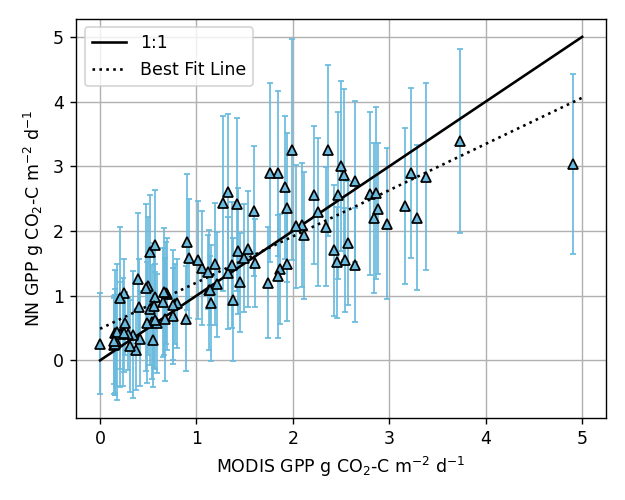

-0.2515922783327238
2.6235947430079833
-0.2515922783327238
2.6235947430079833

-1.1519445024965465
2.073797845142482
          Year      N   RMSE     R2    MBE  Sum_MODIS  Sum_NN   Diff
count   11.000 11.000 11.000 11.000 11.000     11.000  11.000 11.000
mean  2014.000  7.364  0.468  0.511 -0.479      1.103   1.163  0.060
std      3.317  0.809  0.152  0.481  2.269      0.245   0.200  0.284
min   2009.000  6.000  0.245 -0.585 -5.069      0.733   0.790 -0.403
25%   2011.500  7.000  0.338  0.469 -1.209      0.907   1.054 -0.070
50%   2014.000  7.000  0.421  0.687  0.155      1.143   1.155 -0.019
75%   2016.500  8.000  0.595  0.819  0.563      1.269   1.287  0.151
max   2019.000  9.000  0.693  0.896  3.227      1.515   1.516  0.634


,Year,N,RMSE,R2,MBE,Sum_MODIS,Sum_NN,Diff
0,2009,7,0.554,-0.585,-3.453,0.932,1.363,0.432
1,2010,7,0.333,0.816,0.579,1.257,1.184,-0.072
2,2011,7,0.245,0.896,0.547,1.281,1.212,-0.068
3,2012,8,0.645,0.628,3.227,1.515,1.112,-0.403
4,2013,6,0.574,0.687,-0.317,1.322,1.362,0.040
5,2014,7,0.616,0.463,0.155,1.175,1.155,-0.019
6,2015,7,0.335,0.749,-0.062,0.782,0.790,0.008
7,2016,8,0.395,0.823,0.752,1.143,1.049,-0.094
8,2017,8,0.341,0.889,0.474,1.118,1.059,-0.059
9,2018,7,0.693,-0.217,-5.069,0.882,1.516,0.634


In [390]:
GPP_NN='GPP_est_c'
# GPP_NN='GPP_est_c'


Thresh = 182
# DNA = GPP8.loc[GPP8.Daytime<=Thresh].copy()
DNA = All_GPP8.loc[((All_GPP8.index.dayofyear>=205))].copy()
DNA = All_GPP8.loc[All_GPP8.Active_Layer_1>=.3].copy()
DNA['DOY']=DNA.index.dayofyear
DNA['Date']=DNA.index.date
# print(DNA.resample('Y').first()[['DOY','Date']])
DMN = DNA.resample('Y').first()['DOY'].max()
DMX = DNA.resample('Y').last()['DOY'].min()
print('DMN,DMX')
print(DMN,DMX)

print(DNA[['GPP_8d',GPP_NN,GPP_NN+'_CI']].mean()/8)
print(DNA['GPP_8d'].std()/(DNA['GPP_8d'].count()**.5)*stats.t.ppf(0.975,DNA['GPP_8d'].count())/8)

# print(est.params)

X2 = sm.add_constant(DNA['GPP_8d']/8, has_constant='add')
est = sm.OLS(DNA[GPP_NN]/8, X2)
est = est.fit()

print()
print('R2: ',metrics.r2_score(DNA['GPP_8d'],DNA[GPP_NN]))

print('RMSE: ',metrics.mean_squared_error(DNA['GPP_8d'],DNA[GPP_NN])**.5/8)
print()
# print(est.summary())

fig,ax=plt.subplots(1,figsize=(5,4))
ax.errorbar(DNA['GPP_8d']/8,DNA[GPP_NN]/8,DNA[GPP_NN+'_CI']/8,lw=1,elinewidth=1,capsize=2,
                   color='#6abade',markeredgecolor='k',marker='^',ls='None')
X = np.array([0,5])
X2 = sm.add_constant(X, has_constant='add')
ax.plot(X,X,color='k',label = '1:1')
ax.plot(X,est.predict(X2),color='k',label='Best Fit Line',linestyle=':')
ax.set_xlabel('MODIS GPP g CO$_2$-C m$^{-2}$ d$^{-1}$')
ax.set_ylabel('NN GPP g CO$_2$-C m$^{-2}$ d$^{-1}$')


Vals = {
    'Year':[],
    'N':[],
    'RMSE':[],
    'R2':[],
#     'Int':[],
    'MBE':[],
    'Sum_MODIS':[],
    'Sum_NN':[]
}

for y in DNA.index.year.unique():
    temp = DNA.loc[((DNA.index.year==y)
#                     &(DNA.index.dayofyear<=DMX)
                    &(DNA.index.dayofyear>=DMN)
                   )].copy()
    Vals['Year'].append(y)
    Vals['N'].append(temp['GPP_8d'].count())
    Vals['RMSE'].append((metrics.mean_squared_error(temp['GPP_8d'],temp[GPP_NN])**.5)/8)   
    Vals['R2'].append(metrics.r2_score(temp['GPP_8d'],temp[GPP_NN]))
    Vals['MBE'].append((temp['GPP_8d']-temp[GPP_NN]).mean())
    Vals['Sum_MODIS'].append(temp['GPP_8d'].mean()/8)
    Vals['Sum_NN'].append(temp[GPP_NN].mean()/8)
    
ax.legend()
ax.grid()

Vals = pd.DataFrame(Vals)
plt.tight_layout()
plt.savefig(G_Drive+'PhD_Thesis\\Chapter3_Figs/GPP_Est.png',dpi=600)

YD = (DNA.loc[((DNA.index.dayofyear<=DMX)&(DNA.index.dayofyear>=DMN))].resample('Y').mean())

print(metrics.r2_score(YD['GPP_8d'],YD[GPP_NN]))
print(metrics.mean_squared_error(YD['GPP_8d'],YD[GPP_NN])**.5)

print(metrics.r2_score(YD['GPP_8d'],YD[GPP_NN]))
print(metrics.mean_squared_error(YD['GPP_8d'],YD[GPP_NN])**.5)

print()

print(metrics.r2_score(YD['NEE_MODIS'],YD['NEE_est_c']))
print(metrics.mean_squared_error(YD['NEE_MODIS'],YD['NEE_est_c'])**.5)

Vals['Diff'] = Vals['Sum_NN']-Vals['Sum_MODIS']
print(Vals.describe())
Vals




<IPython.core.display.Javascript object>


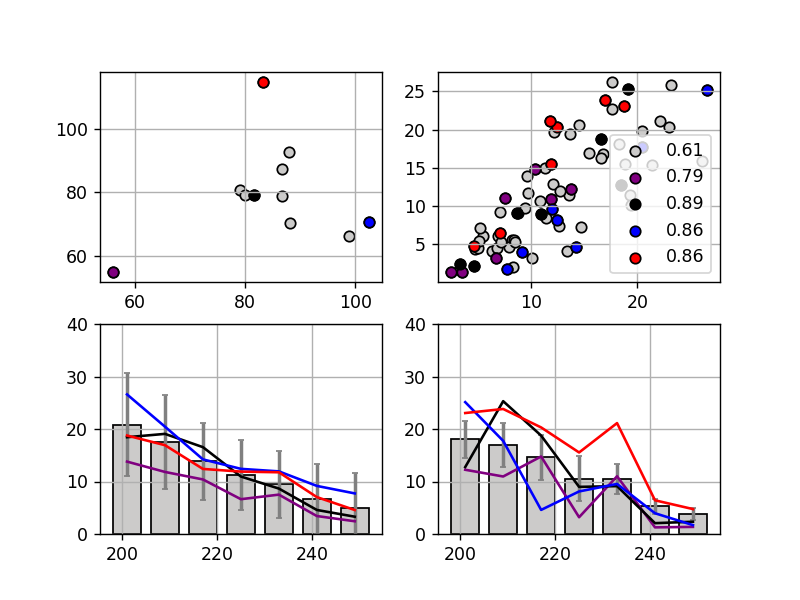

In [35]:
fig,ax=plt.subplots(2,2)

# GPP_NN='GPP_AL_Fix_est_c'
# GPP_NN='GPP_Just_Soil_est_c'


Thresh = 191
DNA = GPP8.loc[GPP8.Daytime<=Thresh].copy()

ax[0,0].scatter(DNA[GPP_NN].resample('Y').sum(),DNA['GPP_8d'].resample('Y').sum(),edgecolor='k',color='#cccbca')
ax[0,1].scatter(DNA[GPP_NN],DNA['GPP_8d'],
                label=np.round(metrics.r2_score(DNA['GPP_8d'],DNA[GPP_NN]),2),
               edgecolor='k',color='#cccbca')

DOY = DNA.groupby(DNA.index.dayofyear).mean()
DOY['GPP_8d_CI'] = DNA.groupby(DNA.index.dayofyear).std()['GPP_8d']/(11**.5)*stats.t.ppf(0.975,11)
ax[0,0].grid()

ax[0,1].grid()



ax[1,0].bar(DOY.index,DOY[GPP_NN],yerr=DOY[GPP_NN+'_CI'],width=6,edgecolor='k',color='#cccbca',
            error_kw=dict(ecolor='gray', lw=2, capsize=2, capthick=1)
           )

ax[1,1].bar(DOY.index,DOY['GPP_8d'],yerr=DOY['GPP_8d_CI'],width=6,edgecolor='k',color='#cccbca',
            error_kw=dict(ecolor='gray', lw=2, capsize=2, capthick=1))

Colors=['purple','black','blue','red']
for y,c in zip([2015,2017,2018,2012],
            Colors):
    ax[1,0].plot(DNA.loc[DNA.index.year==y,'GPP_8d'].index.dayofyear,DNA.loc[DNA.index.year==y,GPP_NN],
                color=c)
    ax[1,1].plot(DNA.loc[DNA.index.year==y,'GPP_8d'].index.dayofyear,DNA.loc[DNA.index.year==y,'GPP_8d'],
                color=c)
    
    ax[0,0].scatter(DNA.loc[DNA.index.year==y][GPP_NN].sum(),DNA.loc[DNA.index.year==y]['GPP_8d'].sum(),
                    edgecolor='k',color=c)
    
    ax[0,1].scatter(DNA.loc[DNA.index.year==y,GPP_NN],DNA.loc[DNA.index.year==y,'GPP_8d'],
                    label=np.round(DNA.loc[DNA.index.year==y,['GPP_8d',GPP_NN]].corr(method='spearman'),2)['GPP_8d'][1],
                   edgecolor='k',color=c)

ax[1,0].set_ylim(0,40)
ax[1,0].grid()
ax[1,1].set_ylim(0,40)
ax[1,1].grid()

ax[0,1].legend()


In [47]:
print(Data.loc[((Data['fco2'].isnull()==False)&(Data.PPFD_Avg<=5)),'Active_Layer_1'].min())

0.3189613124472186


In [51]:
# # print(Data.loc[Data['Season_Class2']=='Growing_Season'].resample('D').max()['VPD'].describe())

# plt.figure()
# plt.plot(Data.loc[Data['Season_Class2']=='Growing_Season'].groupby('DOY').median()['VPD'])

# print(Data.loc[Data.fco2.isnull() == False].groupby('Daytime').describe()['VPD'].T)

# # Data.loc[((Data['Season_Class2']=='Growing_Season')&(Data['Daytime']==0))].resample('D').max()['VPD'].describe()

# # print(Data.loc[Data.index.month == 6,'ER_VPD_Fix_est_c'].describe())

# print(Data.loc[((Data.index.month == 6)&(Data['ER_VPD_Fix_est_c']>.06)),'VPD'].describe())

Benchmarks

GPP_Q10_c :  0.6074032813268615
5.177944411307897
0.5871601952064325

GPP_Hyperbola_c :  0.3926779438575242
6.497501748110103
0.3499307747681475
Range:
       GPP_8d  GPP_Q10_Both_est_c  GPP_AL_Fix_est_c
count 132.000             132.000           132.000
mean   12.260              12.052            13.125
std     8.089               5.190             4.933
min     1.264              -3.269             1.458
25%     5.317               7.900             9.498
50%    10.973              11.839            13.254
75%    17.655              16.772            17.489
max    39.238              19.829            21.582

GPP_Q10_Both_est_c :  0.5826769034628398
const    6.032
GPP_8d   0.491
dtype: float64
5.285296492478136
0.5698642823099236


<IPython.core.display.Javascript object>


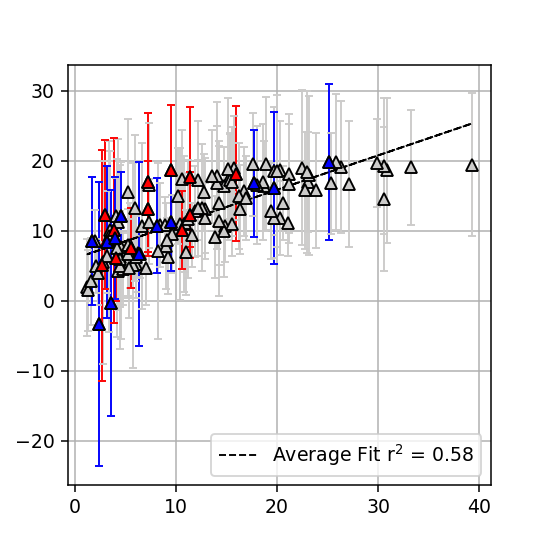

       Slope   RMSE     R2
count 11.000 11.000 11.000
mean   0.621  5.004  0.427
std    0.160  1.786  0.535
min    0.380  2.438 -1.126
25%    0.505  3.788  0.465
50%    0.630  4.711  0.502
75%    0.735  6.331  0.681
max    0.880  8.110  0.809


,Slope,RMSE,R2
Year,,,
2009,0.790,5.742,-1.126
2010,0.630,3.273,0.678
2011,0.880,2.438,0.777
2012,0.500,6.920,0.346
2013,0.610,4.944,0.502
2014,0.380,8.110,0.461
2015,0.800,4.303,0.485
2016,0.420,6.955,0.470
2017,0.510,4.711,0.683


In [66]:


# print(GPP8[[MODIS,'GPP_est_c','GPP_Q10_c','GPP_Hyperbola_c']].corr()[MODIS])

Thresh = 192
# GPP8[['GPP_Combo','GPP_Combo_CI']]=GPP8[['GPP_est_c','GPP_est_c_CI']].copy()
# for v,v2 in zip(['GPP_Combo','GPP_Combo_CI'],['GPP_VPD_Fix_est_c','GPP_VPD_Fix_est_c_CI']):
#     GPP8.loc[GPP8.Daytime<Thresh,v]=GPP8.loc[GPP8.Daytime<Thresh,v2].copy()
# GPP8.loc[GPP8.Daytime>=Thresh,['GPP_Combo','GPP_Combo_CI']]=GPP8.loc[GPP8.Daytime>=Thresh,].copy()

All = [MODIS,
       'GPP_est_c','GPP_est_c_CI',
       'GPP_VPD_Fix_est_c','GPP_VPD_Fix_est_c_CI',
       'GPP_AL_VPD_Fix_est_c','GPP_AL_VPD_Fix_est_c_CI',
       'GPP_AL_VPD_Fix_est_c','GPP_AL_VPD_Fix_est_c_CI',
       'GPP_Q10_c','GPP_Q10_c_CI',
       'GPP_Hyperbola_c','GPP_Hyperbola_c_CI',
       'NEE_est_c','NEE_est_c_CI',
      ]


# print(GPP8[All])
DNA = GPP8.loc[GPP8.Daytime<=Thresh,All].dropna()

# DNA = GPP8.loc[GPP8.index.month>=8,All].dropna()

# print(DNA.corr()[MODIS])

print('Benchmarks')
for GPP_E in ['GPP_Q10_c','GPP_Hyperbola_c']:
    X2 = sm.add_constant(DNA[MODIS], has_constant='add')
    est = sm.OLS(DNA[GPP_E], X2)
    est = est.fit()
    print()
    print(GPP_E,': ',est.rsquared_adj)
    print(metrics.mean_squared_error(DNA[MODIS],DNA[GPP_E])**.5)
    print(metrics.r2_score(DNA[MODIS],DNA[GPP_E]))

GPP_E = 'GPP_VPD_Fix_est_c'
# GPP_E = 'GPP_AL_VPD_Fix_est_c'
GPP_E = 'GPP_AL_VPD_Fix_est_c'
GPP_E = 'GPP_est_c'
# GPP_E = 'GPP_Combo'

X2 = sm.add_constant(DNA[MODIS], has_constant='add')
est = sm.OLS(DNA[GPP_E], X2)
est = est.fit()
rF = est.rsquared_adj
coef = est.params

print('Range:')
print(DNA[[MODIS,GPP_E,'GPP_VPD_Fix_est_c']].describe())

print()
print(GPP_E,': ',est.rsquared_adj)
print(coef)
print(metrics.mean_squared_error(DNA[MODIS],DNA[GPP_E])**.5)
print(metrics.r2_score(DNA[MODIS],DNA[GPP_E]))

fig,ax=plt.subplots(figsize=(4,4))
ax.errorbar(DNA[MODIS],DNA[GPP_E],yerr=DNA[GPP_E+'_CI'],lw=1,elinewidth=1,capsize=2,
                   color='#cccbca',markeredgecolor='k',marker='^',ls='None')

ax.plot(DNA[MODIS],est.predict(X2),color='k',linewidth=1,linestyle='--',
        label='Average Fit $r^2$ = '+(str(np.round(rF,2))),
            zorder=2)
ax.grid()
ax.legend()

Yvals = {'Year':[],
        'Slope':[],
        'RMSE':[],
        'R2':[]}
# for y in DNA.index.dayofyear.unique():
#     DNA2 = DNA.loc[DNA.index.dayofyear==y]
for y in range(2009,2020):
    DNA2 = DNA.loc[DNA.index.year==y]
    X2 = sm.add_constant(DNA2[MODIS], has_constant='add')
    est = sm.OLS(DNA2[GPP_E], X2)
    est = est.fit()
    rF = est.rsquared_adj
    coef = est.params    
    Yvals['Year'].append(y)
    Yvals['Slope'].append(np.round(est.params['GPP_8d'],2))
    Yvals['RMSE'].append(metrics.mean_squared_error(DNA2[MODIS],DNA2[GPP_E])**.5)
    Yvals['R2'].append(metrics.r2_score(DNA2[MODIS],DNA2[GPP_E]))
    if y == 2009:
        ax.errorbar(DNA2[MODIS],DNA2[GPP_E],yerr=DNA2[GPP_E+'_CI'],lw=1,elinewidth=1,capsize=2,
                   color='red',markeredgecolor='k',marker='^',ls='None')
    if y == 2018:
        ax.errorbar(DNA2[MODIS],DNA2[GPP_E],yerr=DNA2[GPP_E+'_CI'],lw=1,elinewidth=1,capsize=2,
                   color='blue',markeredgecolor='k',marker='^',ls='None')
    
Yvals = pd.DataFrame(Yvals).set_index('Year')
print(Yvals.describe())
Yvals

In [178]:

Dpath = G_Drive+'FishIsland_Outputs/Benchmark_30m.csv'
Benchmark = pd.read_csv(Dpath,index_col=['datetime'],parse_dates=['datetime'])
print(Benchmark.loc[((Benchmark['co2_flux'].isnull()==False)&(Benchmark['Daytime']==0)),'DOY'].describe())
print(Benchmark.loc[((Benchmark['co2_flux'].isnull()==False)&(Benchmark['PPFD_Avg']<=10)),'Active_Layer_1'].describe())

count   239.000
mean    231.033
std      12.147
min     206.000
25%     224.000
50%     231.000
75%     237.000
max     256.000
Name: DOY, dtype: float64
count   325.000
mean      0.409
std       0.052
min       0.268
25%       0.380
50%       0.408
75%       0.444
max       0.524
Name: Active_Layer_1, dtype: float64


In [6]:
print(Data.loc[((Data.index.year == 2017)&(Data.index.dayofyear==191)),['ER_est','ER_Q10']].describe())
print(Data.loc[((Data.index.year == 2017)&(Data.index.dayofyear==233)),['ER_est','ER_Q10']].describe())

       ER_est  ER_Q10
count  24.000  24.000
mean    2.110   1.028
std     0.405   0.196
min     1.502   0.761
25%     1.693   0.866
50%     2.215   0.989
75%     2.492   1.152
max     2.628   1.358
       ER_est  ER_Q10
count  24.000  24.000
mean    0.776   0.845
std     0.139   0.122
min     0.536   0.717
25%     0.686   0.765
50%     0.765   0.779
75%     0.869   0.900
max     1.029   1.140


In [7]:
DNA = Data.loc[Data['Daytime']==0,['fco2','NEE_est','ER_est','ER_Q10']].dropna()

print()
print('NEE_est')
print(metrics.r2_score(DNA['fco2'],DNA['NEE_est']))
print(metrics.mean_squared_error(DNA['fco2'],DNA['NEE_est'])**.5)
print()
print('ER_est')
print(metrics.r2_score(DNA['fco2'],DNA['ER_est']))
print(metrics.mean_squared_error(DNA['fco2'],DNA['ER_est'])**.5)
print()
print('ER_Q10')
print(metrics.r2_score(DNA['fco2'],DNA['ER_Q10']))
print(metrics.mean_squared_error(DNA['fco2'],DNA['ER_Q10'])**.5)

# plt.figure(figsize=(4,4))
# plt.scatter(DNA['fco2'],DNA['NEE_est'])
# plt.scatter(DNA['fco2'],DNA['ER_est'])
# plt.scatter(DNA['fco2'],DNA['ER_Q10'])

print(Data.loc[Data.index.month==6,['ER_est','ER_est_CI','PPFD_Avg']].describe())
print(Data.loc[Data.index.month==6,['ER_Q10','ER_Q10_CI']].mean())


NEE_est
0.5877760008265802
0.20411871567284223

ER_est
0.5896815768015796
0.20364638233436533

ER_Q10
0.48120124234432005
0.22898954525207163
        ER_est  ER_est_CI  PPFD_Avg
count 7920.000   7920.000  7920.000
mean     4.090      1.820   512.570
std      1.133      0.440   473.112
min      1.016      0.398     0.272
25%      3.263      1.531    93.351
50%      4.069      1.823   348.407
75%      4.846      2.118   866.712
max      7.173      3.177  1621.594
ER_Q10      0.579
ER_Q10_CI   0.007
dtype: float64


In [59]:
# print(Data.loc[((Data['fco2'].isnull()==False)),'TDiff'].describe())
# print(Data.loc[((Data['fco2'].isnull()==False)&(Data['Daytime']==0)),'TDiff'].describe())
# print(Data.loc[Data['Study_Season']==1])

       GPP_Q10  GPP_est  NEE_est
count 5423.000 5423.000 5423.000
mean     0.000    0.000    0.922
std      0.000    0.000    0.246
min      0.000    0.000    0.463
25%      0.000    0.000    0.736
50%      0.000    0.000    0.880
75%      0.000    0.000    1.075
max      0.000    0.000    2.094
         ER_Q10    ER_est  ER_est_CI
count 30918.000 30941.000  30941.000
mean      0.774     0.941      0.870
std       0.345     0.362      0.403
min       0.206     0.202      0.229
25%       0.526     0.679      0.547
50%       0.701     0.859      0.795
75%       0.943     1.136      1.116
max       3.619     3.439      2.407


<IPython.core.display.Javascript object>


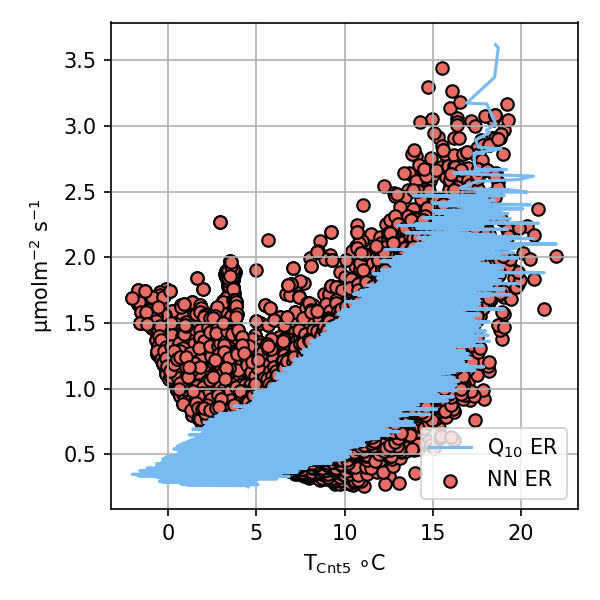

In [67]:
print(Data.loc[((Data['Study_Season']==1)&(Data['Daytime']==0)),['GPP_Q10','GPP_est','NEE_est']].describe())

print(Data.loc[((Data['Study_Season']==1)),['ER_Q10','ER_est','ER_est_CI']].describe())



# DNA = Data.loc[Data['Study_Season']==1,['ER_est','ER_est_CI','ER_Q10','ER_Q10_CI','Temp_5_1']].dropna().sort_values(by='Temp_5_1')
DNA = Data.loc[Data['Season_Class2']=='Growing_Season',
               ['NEE_est','ER_est','ER_est_CI','ER_Q10','ER_Q10_CI','Temp_5_1','Temp_5_2']].dropna().sort_values(by='Temp_5_1')


fig,ax=plt.subplots(figsize=(4,4))

# ax.plot(DNA['Temp_5_1'],DNA['ER_est'],color='#e86d64',label='NN ER')
ax.scatter(DNA['Temp_5_2'],DNA['ER_est'],color='#e86d64',edgecolor='k',label='NN ER')

# ax.fill_between(DNA['Temp_5_1'],DNA['ER_est']+DNA['ER_est_CI'],DNA['ER_est']-DNA['ER_est_CI'],
#                 facecolor='#e86d64'+'1A',edgecolor='k',linestyle=':')

ax.plot(DNA['Temp_5_2'],DNA['ER_Q10'],color='#77bbf2',label='$Q_{10}$ ER')
# ax.scatter(DNA['Temp_5_1'],DNA['fco2'])

# print(metrics.r2_score(DNA['fco2'],DNA['ER_est']))
# print(metrics.r2_score(DNA['fco2'],DNA['NEE_est']))
# print(metrics.r2_score(DNA['fco2'],DNA['ER_Q10']))


ax.set_ylabel(Units[0])
# print(Units[0])
ax.set_xlabel('$T_{Cnt5}$ $\circ C$')
ax.legend(loc=4)
ax.grid()

plt.tight_layout()
plt.savefig(G_Drive+'PhD_Thesis\\Chapter3_Figs/Q10.png',dpi=600)

<IPython.core.display.Javascript object>


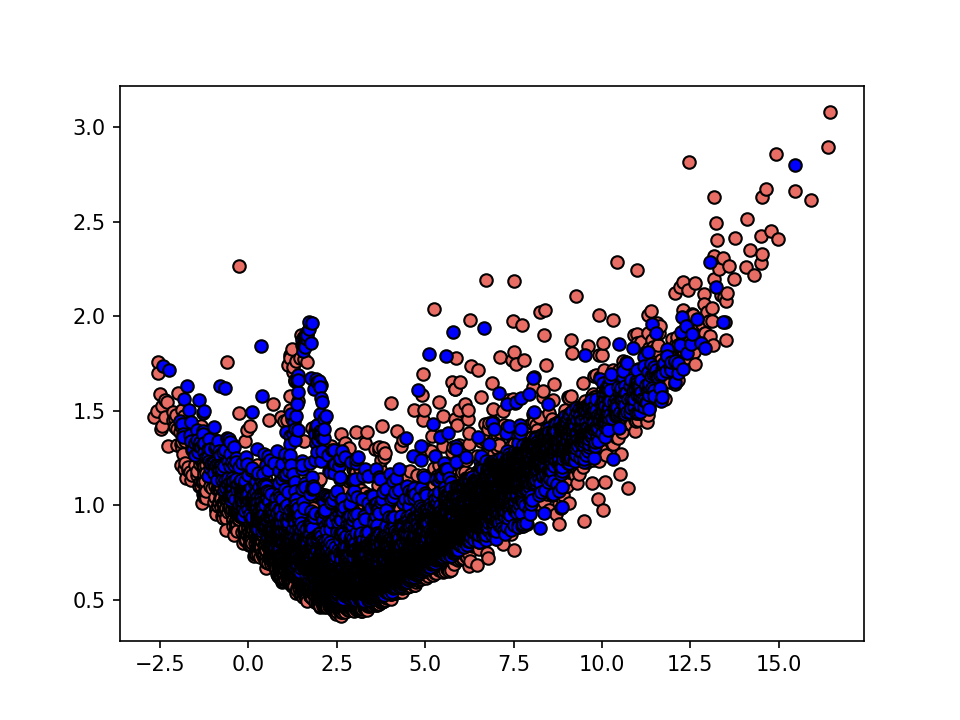

In [80]:
# print(DNA[])
DNA['Diff']=DNA['Temp_5_1']-DNA['Temp_5_2']
DNA['Diff'].describe()
# DNA.loc[DNA['Diff']<-0.95]

DNA2 = DNA.loc[((DNA['Diff']<DNA['Diff'].quantile(.5))&(DNA['Diff']>DNA['Diff'].quantile(.25)))].copy()
DNA3 = DNA.loc[((DNA['Diff']<DNA['Diff'].quantile(.75))&(DNA['Diff']>DNA['Diff'].quantile(.5)))].copy()

fig,ax=plt.subplots()
ax.scatter(DNA2['Temp_5_1'],DNA2['ER_est'],color='#e86d64',edgecolor='k',label='NN ER')
ax.scatter(DNA3['Temp_5_1'],DNA3['ER_est'],color='blue',edgecolor='k',label='NN ER')

In [1667]:

# print(Data[['GPP_Q10_c','GPP_Hyperbola_c','GPP_est_c','NEE_est_c']].resample('D').sum().corr()**2)
# print(Data[['GPP_Q10_c','GPP_Hyperbola_c','GPP_est_c','NEE_est_c']].resample('D').sum().dropna().describe())
# GPP_est
# plt.figure(figsize=(4,4))
# plt.scatter(Data['GPP_est'],Data['GPP_Hyperbola'])
# print(Data.loc[((Data['Study_Year']==1)),
#                ['C_U','C_L']].sum()/11)


# print(Data.loc[((Data['Study_Year']==1)),
#                ['ER_est_c_U','ER_est_c_L']].sum()/11)

# print(Data.loc[((Data['Study_Year']==1)),
#                ['GPP_est_c_U','GPP_est_c_L']].sum()/11)

# print(Data.loc[((Data['Study_Year']==1)),
#                ['GPP_8d']].sum()/11)

print(Data.loc[Data['Daytime']==0,['fco2','Active_Layer_1']].dropna())

                      fco2  Active_Layer_1
2017-07-25 03:00:00 0.9208          0.3448
2017-07-26 03:00:00 0.8522          0.3484
2017-07-27 02:00:00 0.7857          0.3518
2017-07-27 03:00:00 0.5582          0.3520
2017-07-28 02:00:00 1.0105          0.3554
...                    ...             ...
2017-09-12 22:00:00 0.6611          0.5015
2017-09-12 23:00:00 0.7611          0.5017
2017-09-13 00:00:00 0.5747          0.5018
2017-09-13 01:00:00 0.6300          0.5019
2017-09-13 02:00:00 0.6549          0.5020

[110 rows x 2 columns]


In [1668]:
# print(Data)
DNA = Data.loc[Data['Study_Season']==1,['Temp_5_2','Temp_5_1','Temp_15_2']].dropna()

DNA.corr()**2

X2 = sm.add_constant(DNA['Temp_5_1'], has_constant='add')
est = sm.OLS(DNA['Temp_15_2'], X2)
est = est.fit()
# rF = est.rsquared_adj
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:              Temp_15_2   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.694
Method:                 Least Squares   F-statistic:                 7.023e+04
Date:                Thu, 14 Apr 2022   Prob (F-statistic):               0.00
Time:                        16:33:59   Log-Likelihood:                -45801.
No. Observations:               30918   AIC:                         9.161e+04
Df Residuals:                   30916   BIC:                         9.162e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4095      0.010    -40.578      0.0

In [1217]:
# T = Data.loc[((Data['Study_Year']==1)),['GPP_d','GPP_est_c']].resample('Y').sum()
# T['NDVI_FI_LCP'] = Data.loc[((Data['Study_Year']==1)),['NDVI_FI_LCP']].resample('Y').max()

# plt.figure(figsize=(4,4))
# plt.scatter(GPPY['GPP_8d'],GPPY['GPP_est_c'])#,c=T['NDVI_FI_LCP'])
# # plt.colorbar()

# print(GPPY[['GPP_8d','GPP_est_c']].corr())



In [356]:
A = Data.loc[((Data['Study_Year']==1)
                 )][FDTS+Mean+['NEE_est','NME_est']].resample('Y').mean()
# print(A.corr())
A[['NEE_est_cum','NME_est_cum','GPP_8d']] = Data.loc[((Data['Study_Year']==1)#&(Set.index.year!=2018)
             )][['NEE_est','NME_est','GPP_8d']].resample('Y').sum()

A['June'] = Data.loc[((Data.index.month==6)),'Air_Temp'].resample('Y').mean()
A['July'] = Data.loc[((Data.index.month==7)),'Air_Temp'].resample('Y').mean()
A['August'] = Data.loc[((Data.index.month==8)),'Air_Temp'].resample('Y').mean()
A['September'] = Data.loc[((Data.index.month==9)),'Air_Temp'].resample('Y').mean()

A['Snowmelt'] = Data.loc[Data['NDSI_FI_LCP']<0.0,'DOY'].resample('Y').min()
A['Flood'] = Data.loc[Data['NDWI_FI_LCP']<0.0,'DOY'].resample('Y').min()

A[['NDVI_max','Snowfall','GPP_mx']] = Data.loc[Data['Study_Year']==1].resample('Y').max()[['NDVI_FI_LCP','DOY','GPP_8d']]
# A[['NDVI_min','DOY_mn']] = Set.loc[Set['Study_Year']==1].resample('Y').min()[['NDVI_FI_LCP','DOY']]
# A['D_NDVI_max'] = A['NDVI_max'] - A['NDVI_min']
A[['GPP_8d_cum','Study_Year','C']] = Data.loc[Data['Study_Year']==1].resample('Y').sum()[['GPP_8d','Study_Year','C']]

A['Snow-free season length']=(A['Study_Year']/24).astype(int)

for y in np.arange(2009,2020):
    Set = A.loc[A.index.year!=y].copy()
    r,p = r_pvalues(Set,method='spearman')
    r = r[['NEE_est','NME_est','C']].copy().astype(float)
    p = p[['NEE_est','NME_est','C']].copy().astype(float)

    if y == 2009:
        C = r.copy()
        P = p.copy()
    else:
        C = C.append(r)
        P = P.append(p)

Sel=['Snowmelt',
'Flood',
'NDVI_max',
'Snowfall',
'Snow-free season length',
'June',
'July',
'VPD',
'August',
'September',
'GPP_8d',
    ]
# print()
Corr = C.groupby(C.index).median()
Porr = P.groupby(P.index).median()

# Corr[Porr>.1]=np.nan
# Corr

Corr.loc[Corr.isnull().sum(axis=1)<3]

Corr = Corr.loc[Corr.index.isin(Sel)].round(2)#.sort_index(by=Sel)
Corr = Corr.reset_index().fillna('--')
Corr
Corr['Cats']=Corr['index'].astype("category")

Corr['Cats']=Corr['Cats'].cat.set_categories(Sel)
print(Corr.sort_values(["Cats"]).drop(['Cats'],axis=1).set_index('index'))




                         NEE_est  NME_est       C
index                                            
Snowmelt                 -0.3500   0.6200 -0.2700
Flood                    -0.2800   0.7900 -0.2300
NDVI_max                 -0.7100   0.5300 -0.7300
Snowfall                  0.5700  -0.3500  0.4200
Snow-free season length   0.6400  -0.4500  0.5000
June                      0.1600  -0.1900  0.0300
July                      0.6800  -0.0800  0.6400
VPD                      -0.0100   0.4300 -0.0700
August                    0.0700   0.5000  0.0100
September                 0.3900   0.3300  0.3000
GPP_8d                    0.4300  -0.5000  0.2600


In [248]:
# # print(Data.loc[Data['Study_Season']==1].resample('D').mean()['Air_Temp'].describe())
# print(Data.loc[Data['Study_Season']==1].resample('D').mean()[['Temp_5_1','Temp_15_1']].describe())
# Data['Temp_10'] = (Data['Temp_5_1']+Data['Temp_15_1'])/2
# Data.loc[Data['Study_Season']==1].resample('D').mean()['Temp_10'].describe()

# print(Data.loc[Data['Study_Season']==1].resample('Y').max()['Active_Layer_1'])

# print(Data.loc[Data['Study_Season']==1].resample('Y').mean()['Table_1'])

In [328]:
Data['GPP_8d']=np.random.rand(Data.shape[0])

D = Data.loc[((Data['Daytime'].isnull()==False)&
             (Data['Season_Class']=='Mid_Season'))][FDTS+Flux+Mean+['GPP_8d']].resample('D').mean()
H = Data.loc[((Data['Daytime'].isnull()==False)&
             (Data['Season_Class']=='Mid_Season'))][FDTS+Flux+Mean+['GPP_8d']].copy()


f = 'NME_est'
for s,l in zip([H,D,GPP8,GPP16,GPP24,GPP32,GPP48,GPPY],
               ['F','1-Day','8-Day','16-Day','24-Day','32-Day','48-Day','96-Day']):
#     print(s['u*'])
    s = s.loc[((s.index.year>=2009)&(s.index.year<=2019))]
    s = s.dropna()
    if l == '96-Day':
        r,p = r_pvalues(s,method='spearman')
    else:
        r,p = r_pvalues(s)
    r = r[[f]].copy().astype(float)
    p = p[[f]].copy().astype(float)
    r[p>0.1] = np.nan
    if l == 'F':
        Corr = r.copy()
    else:
        Corr[l] = r[[f]].copy()
Corr = Corr.drop([
#     f,
#   '96-Day'
],axis=1).drop(['NME_est'])
Corr[Corr**2<.25] = np.nan

Sel=['NR_Wm2_Avg',#'u*','wind_speed',
     'Active_Layer_1','GPP_8d',
     'Table_1','NEE_est','Air_Temp','NDVI']
# RI = 

# Corr = np.sign(Corr)*(Corr)**2
Corr = Corr.loc[Corr.index.isin(Sel)].round(2)#.sort_index(by=Sel)
Corr = Corr.reset_index().fillna('--')
# Corr
Corr['Cats']=Corr['index'].astype("category")

Corr['Cats']=Corr['Cats'].cat.set_categories(Sel)
Corr.sort_values(["Cats"]).drop(['Cats'],axis=1).set_index('index')

,NME_est,1-Day,8-Day,16-Day,24-Day,32-Day,48-Day,96-Day
index,,,,,,,,
NR_Wm2_Avg,0.7800,0.7200,0.7900,0.8100,0.8400,0.8900,0.9300,0.7900
Active_Layer_1,-0.6400,-0.6600,-0.7000,-0.7300,-0.7800,-0.8300,-0.8900,--
GPP_8d,--,--,--,--,0.5000,--,--,--
Table_1,--,--,--,--,--,--,--,--
NEE_est,-0.6200,-0.6800,-0.7300,-0.7300,-0.7200,-0.7100,-0.8100,--
Air_Temp,--,--,--,--,--,0.5000,--,--


In [327]:
# print(D[['GPP_8d','NEE_est']].corr())
f = 'NEE_est'
for s,l in zip([H,D,GPP8,GPP16,GPP24,GPP32,GPP48,GPPY],
               ['F','1-Day','8-Day','16-Day','24-Day','32-Day','48-Day','96-Day']):
#     print(s['GPP_8d'])
    s = s.loc[((s.index.year>=2009)&(s.index.year<=2019))]
    s = s.dropna()
    if l == '96-Day':
        r,p = r_pvalues(s,method='spearman')
    else:
        r,p = r_pvalues(s)
    r = r[[f]].copy().astype(float)
    p = p[[f]].copy().astype(float)
    r[p>0.05] = np.nan
    if l == 'F':
        Corr = r.copy()
    else:
        Corr[l] = r[[f]].copy()
Corr = Corr.drop([
#     f,
#     '96-Day'
                 ],axis=1).drop(['NEE_est'])
Corr[Corr**2<=.25] = np.nan
# Corr = Corr**2
Corr = Corr[Corr.isnull().sum(axis=1)<Corr.shape[1]]

Sel=['PPFD_Avg','VPD','Temp_5_1','Active_Layer_1','Table_1',
     'Air_Temp','GPP_8d','NDVI_FI_LCP']

Corr = Corr.loc[Corr.index.isin(Sel)].round(2)#.sort_index(by=Sel)
Corr = Corr.reset_index().fillna('--')
# Corr
Corr['Cats']=Corr['index'].astype("category")

Corr['Cats']=Corr['Cats'].cat.set_categories(Sel)
Corr.sort_values(["Cats"]).drop(['Cats'],axis=1).set_index('index')
# Corr
# print(r)

,NEE_est,1-Day,8-Day,16-Day,24-Day,32-Day,48-Day,96-Day
index,,,,,,,,
PPFD_Avg,-0.5400,-0.5200,--,--,--,-0.5600,-0.7200,--
VPD,--,--,-0.5700,-0.6300,-0.6400,-0.7200,-0.5400,--
Temp_5_1,--,--,-0.5000,-0.5200,--,--,--,--
Active_Layer_1,--,--,--,--,--,--,0.6100,--
Table_1,--,--,0.5100,0.5100,--,--,--,--
Air_Temp,--,--,-0.5500,-0.6000,-0.5600,-0.6200,--,--
GPP_8d,--,--,-0.6400,-0.6900,-0.6800,-0.6900,--,--


# Raz-Yasef

In [251]:
print('Kohnert')

print(Data.loc[(((Data.index.year == 2013)|(Data.index.year == 2012))&(
    Data.index.month==7)),['NME_est_L','NME_est_U']].mean())


print('Skeeter')


print(-1.5/Data.loc[(((Data.index.year == 2016)&(Data.index.month == 7)&(Data.index.day>=10))|
           ((Data.index.year == 2016)&(Data.index.month == 8)&(Data.index.day<=7))
          ),['NEE_est_c']].resample('Y').mean())


print(0.008/Data.loc[(((Data.index.year == 2016)&(Data.index.month == 7)&(Data.index.day>=10))|
           ((Data.index.year == 2016)&(Data.index.month == 8)&(Data.index.day<=7))
          ),['NME_est_c']].resample('Y').mean())


print('Dengel')
Comp = {'Year':[],
        'NEE_est_Mean':[],
        'Ta':[],
        'NME_est_Mean':[],
#         'NME_est_SE':[]
        }

for y in range(2013,2020):
#     print(y)
    Comp['Year'].append(y)
    T = Data.loc[(
#             (Data['Study_Season']==1)&
                ((Data.index.year == y)&(Data.index.month >= 6)&(Data.index.month<=9))),
                       ['Air_Temp']].resample('Y').mean().values[0][0]
    
    Comp['Ta'].append(T)
    for f in ['NEE_est','NME_est']:
#         print(f)
        M = Data.loc[(
#             (Data['Study_Season']==1)&
                ((Data.index.year == y)&(Data.index.month >= 6)&(Data.index.month<=9))),
                       [f]].resample('Y').mean()
        CI = Data.loc[(
#             (Data['Study_Season']==1)&
                ((Data.index.year == y)&(Data.index.month >= 6)&(Data.index.month<=9))),
                       [f+'_CI']].resample('Y').mean()
        Comp[f+'_Mean'].append(M.applymap(lambda x: '{0:.2f}'.format(x)).values[0][0]+' [CI95% +/- '+
                              CI.applymap(lambda x: '{0:.2f}'.format(x)).values[0][0]+']'#' 1 SE ('+
#                               SE.applymap(lambda x: '{0:.2f}'.format(x)).values[0][0]+')'
                              )
    
Comp = pd.DataFrame(data=Comp) 
print(Comp)
Comp
print()

print('Raz-Yasef')
Conv = 1e3/(5*24*3600)
U = 510.3*Conv*mult['fco2']*24
SE = 85.5*Conv*mult['fco2']*24

print(U,SE)


U = 7.0*Conv*mult['fch4']*24*1e3
SE = 0.8*Conv*mult['fch4']*24*1e3
print(U,SE)

Kohnert
NME_est_L   31.2956
NME_est_U   39.8868
dtype: float64
Skeeter
            NEE_est_c
2016-12-31    37.2508
            NME_est_c
2016-12-31     6.4644
Dengel
   Year            NEE_est_Mean     Ta            NME_est_Mean
0  2013  -0.31 [CI95% +/- 0.51] 8.0014  24.61 [CI95% +/- 6.89]
1  2014  -0.40 [CI95% +/- 0.47] 7.4627  23.97 [CI95% +/- 6.04]
2  2015  -0.36 [CI95% +/- 0.46] 7.5516  21.96 [CI95% +/- 6.12]
3  2016  -0.37 [CI95% +/- 0.48] 8.0732  23.63 [CI95% +/- 6.79]
4  2017  -0.35 [CI95% +/- 0.39] 8.8038  24.95 [CI95% +/- 5.13]
5  2018   0.06 [CI95% +/- 0.66] 5.4982  22.72 [CI95% +/- 8.57]
6  2019  -0.42 [CI95% +/- 0.46] 7.5263  25.34 [CI95% +/- 5.76]

Raz-Yasef
1.225812042 0.20538297
0.01681498 0.0019217120000000001


In [252]:
# Holl
Comp = {'Year':[],
        'NEE_est_c_Mean':[],
        'NEE_est_c':[],
        'NEE_est_c_CI':[],
        }

for y in range(2009,2017):
#     print(y)
    Comp['Year'].append(y)
    for f in ['NEE_est_c']:
#         print(f)
        M = Data.loc[
            ((Data.index.year==y)&
                ((Data.index.dayofyear >= 200)&(Data.index.dayofyear <= 235))),
                       [f]].resample('Y').sum()
        CI = Data.loc[
            ((Data.index.year==y)&
                ((Data.index.dayofyear >= 200)&(Data.index.dayofyear <= 235))),
                       [f+'_CI']].resample('Y').sum()
        SE = Data.loc[
            ((Data.index.year==y)&
                ((Data.index.dayofyear >= 200)&(Data.index.dayofyear <= 235))),
                       [f+'_CI']].resample('Y').sum()
        Comp[f].append(M.values[0][0])
        Comp[f+'_CI'].append(CI.values[0][0])  
        Comp[f+'_Mean'].append(M.applymap(lambda x: '{0:.2f}'.format(x)).values[0][0]
                               +' $CI_{95%} \pm$ '+
                              SE.applymap(lambda x: '{0:.2f}'.format(x)).values[0][0])
    
Comp = pd.DataFrame(data=Comp) 
# print(Comp[])
Comp[['NEE_est_c','NEE_est_c_CI']].mean()


NEE_est_c      -24.7405
NEE_est_c_CI    12.5837
dtype: float64

In [253]:
print((Data.loc[Data['Season_Class2']=='Growing_Season',
         ['C_U','C_L']].resample('Y').sum()).round(4))


                C_U       C_L
2009-12-31 -22.9322 -110.2512
2010-12-31 -20.6897  -89.6849
2011-12-31 -10.9129  -91.5045
2012-12-31   3.7744  -80.7497
2013-12-31 -13.5151  -94.1422
2014-12-31 -24.0782 -102.6354
2015-12-31 -16.3111  -95.2418
2016-12-31 -21.7609 -100.6808
2017-12-31 -21.5091  -84.8556
2018-12-31  34.3381  -72.8296
2019-12-31 -25.2437 -106.1843


<IPython.core.display.Javascript object>


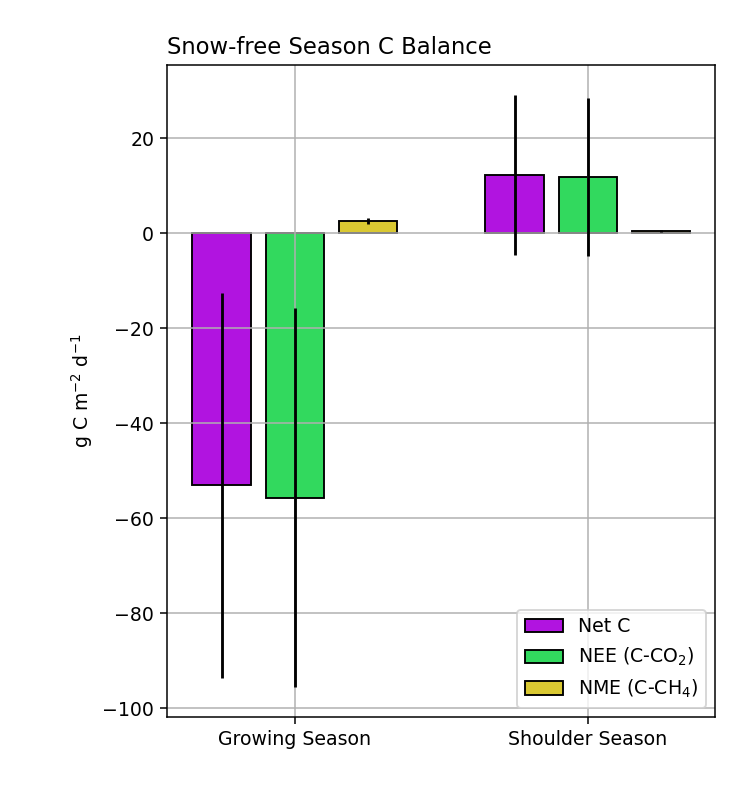

                 NEE_est_c  NEE_est_c_CI  NME_est_c  NME_est_c_CI        C  \
Season_Class2                                                                
Shoulder_Season    11.9216       16.6355     0.3841        0.2156  12.3057   
Growing_Season    -55.6720       39.9063     2.5992        0.5446 -53.0727   

                   C_CI      xi  
Season_Class2                    
Shoulder_Season 16.8511 12.0000  
Growing_Season  40.4509  8.0000  
NEE_est_c      -43.7504
NEE_est_c_CI    56.5418
NME_est_c        2.9833
NME_est_c_CI     0.7602
C              -40.7670
C_CI            57.3020
xi              20.0000
dtype: float64


In [254]:
S = (Data.groupby(Data['Season_Class2']).sum()[['NEE_est_c','NEE_est_c_CI','NME_est_c','NME_est_c_CI',    
    'C','C_CI','xi']]).dropna().sort_values(by='xi')/11

# print(S)

S['xi'] = (Data.groupby(Data['Season_Class2']).median()[['xi']]*24).round(2).dropna().sort_values(by='xi')
# print(S)
S['xi']/=6

S[S==0] = np.nan
S = S.dropna()

NEE_c = '#32d95e'
NME_c = '#d9c832'
C_c = '#b114e0'

plt.figure(figsize=(4,4.25))
plt.bar(S['xi'],S['C'],yerr=S['C_CI'],color=C_c,edgecolor='k',label='Net C')
plt.bar(S['xi']+1,S['NEE_est_c'],yerr=S['NEE_est_c_CI'],color=NEE_c,edgecolor='k',label='NEE (C-CO$_2$)')
plt.bar(S['xi']+2,S['NME_est_c'],yerr=S['NME_est_c_CI'],color=NME_c,edgecolor='k',label='NME (C-CH$_4$)')


plt.xticks([9,13],['Growing Season','Shoulder Season'])
plt.ylabel('g C m$^{-2}$ d$^{-1}$')
plt.legend(loc=4)
plt.grid()
plt.title('Snow-free Season C Balance', loc='left')
plt.tight_layout()
Data.groupby(Data.index.month).mean()[['NEE_est','NEE_est_CI','NME_est','NME_est_CI']]
print((S).round(4))
print((S).round(4).sum())

plt.savefig(G_Drive+'PhD_Thesis\\Chapter3_Figs/Seasonal.png',dpi=600)

In [256]:
print(S['NME_est_c']/((S['NME_est_c'])+S['NEE_est_c']))
# D = Data.loc[((Data.index.month<=9)&(Data.index.month>=6)&(Data.index.year==2018))].resample('D').mean()
# D2 = Data.loc[((Data.index.month<=9)&(Data.index.month>=6)&(Data.index.year!=2018))].resample('D').mean()

# plt.figure()
# plt.plot(D.index.dayofyear,D['NEE_est'])
# plt.plot(D2.index.dayofyear,D2['NEE_est'])

Season_Class2
Shoulder_Season    0.0312
Growing_Season    -0.0490
dtype: float64


In [257]:
Daily = Data.resample('D').max()[['NDWI_FI_LCP','Air_Temp_ERA5_Scaled']]

# Data['NDWI_FI_LCP'].max()

Daily['Flood_Class'] = 'Not Flooded'
Daily.loc[(((Daily.index.month==5)|((Daily.index.month==6)))&(Daily['NDWI_FI_LCP']>0.075)),'Flood_Class']='Possible'
# Data.loc[(((Data.index.month==5)|((Data.index.month==6)))&(Data['Flood']>0.1)),'Flood_Class']='Possible'
Daily.loc[(((Daily.index.month==5)|((Daily.index.month==6)))&(Daily['NDWI_FI_LCP']>0.15)),'Flood_Class']='Probable'
Daily['Year'] = Daily.index.year
Fy = Daily.groupby(['Year','Flood_Class']).max()['NDWI_FI_LCP']

Fy.unstack().round(2)

Flood_Class,Not Flooded,Possible,Probable
Year,,,
2009,0.1400,0.1400,0.2500
2010,0.2300,0.0900,NaN
2011,0.1200,0.0900,NaN
2012,0.1300,NaN,NaN
2013,0.1700,0.1000,NaN
2014,0.1000,0.0800,NaN
2015,0.1800,NaN,NaN
2016,0.1100,0.0900,NaN
2017,0.0700,0.0800,NaN


# Comparissons

NEE_est_c      -0.3733
NEE_est_c_CI    0.4824
NME_est_c       0.0255
NME_est_c_CI    0.0065
dtype: float64
            NEE_est_c  NEE_est_c_CI  NEE_est_c_L  NEE_est_c_U  NME_est_c  \
2009-12-31    -0.7200        0.4500      -1.1700      -0.2700    28.3600   
2010-12-31    -0.6000        0.3500      -0.9600      -0.2500    26.4100   
2011-12-31    -0.5600        0.4100      -0.9700      -0.1500    26.8900   
2012-12-31    -0.4300        0.4300      -0.8600       0.0000    29.4100   
2013-12-31    -0.5900        0.4100      -1.0000      -0.1700    27.9800   
2014-12-31    -0.6900        0.4000      -1.0900      -0.2800    26.5800   
2015-12-31    -0.6000        0.4100      -1.0100      -0.2000    23.7100   
2016-12-31    -0.6600        0.4100      -1.0700      -0.2600    26.4300   
2017-12-31    -0.5800        0.3300      -0.9100      -0.2600    28.0100   
2018-12-31    -0.2300        0.5500      -0.7800       0.3300    25.5600   
2019-12-31    -0.7100        0.4200      -1.1300      -0.

<IPython.core.display.Javascript object>


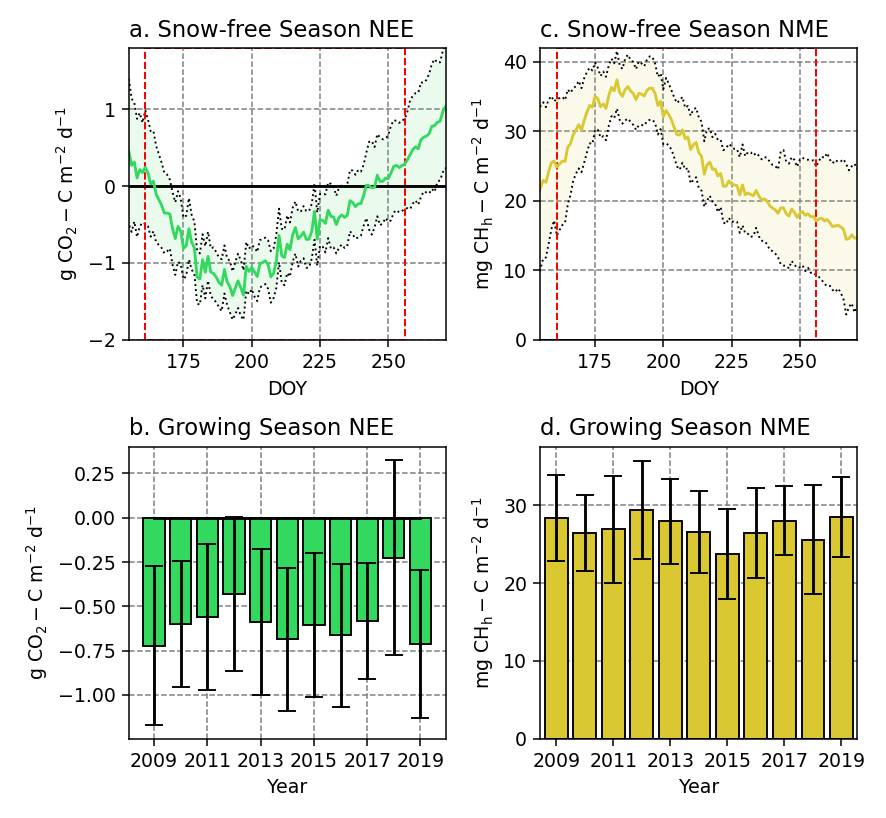

In [258]:
print(Data.loc[((Data['Study_Season']==1)),['NEE_est_c','NEE_est_c_CI','NME_est_c','NME_est_c_CI']].mean()*24)
ecolor='k'

Data.loc[((Data['Study_Year']==1))].resample('D').mean()[['NEE_est_c','NME_est_c']].corr()**2
A_sum = Data.loc[((Data['Season_Class2']=='Growing_Season')),
                 ['NEE_est_c','NEE_est_c_CI','NEE_est_c_L','NEE_est_c_U',
                  'NME_est_c','NME_est_c_CI','NME_est_c_L','NME_est_c_U',
                  'C','C_CI','Air_Temp']].resample('Y').mean()*24
A_sum[['NME_est_c','NME_est_c_CI','NME_est_c_L','NME_est_c_U']]*=1e3
print(A_sum.round(2))

Temp = 'Pot'
Temp = Data.loc[((Data['Study_Year']==1)),
     ['NEE_est_c','NEE_est_c_CI','NME_est_c','NME_est_c_CI','Study_Year',
     ]].resample('D').mean()*24
Temp[['NME_est_c','NME_est_c_CI']]*=1e3
M_sum = Temp[['NEE_est_c','NEE_est_c_CI','NME_est_c','NME_est_c_CI'#,'DOY'
     ]].groupby(Temp.index.dayofyear).mean()

fig,((ax3,ax4),(ax1,ax2)) = plt.subplots(2,2,figsize=(6.5,6))#,sharex='col')#,sharey='row')

NEE_c = '#32d95e'
NME_c = '#d9c832'

ax1.plot(A_sum.index.year,A_sum['NEE_est_c']*0,color='k')
ax2.plot(A_sum.index.year,A_sum['NEE_est_c']*0,color='k')

ax1.bar(A_sum.index.year,A_sum['NEE_est_c'],yerr=A_sum['NEE_est_c_CI'],capsize=5,edgecolor='k',facecolor=NEE_c)
ax2.bar(A_sum.index.year,A_sum['NME_est_c'],yerr=A_sum['NME_est_c_CI'],capsize=5,edgecolor='k',facecolor=NME_c)

ax1.set_axisbelow(True)
ax1.grid(color='gray', linestyle='dashed')
ax2.set_axisbelow(True)
ax2.grid(color='gray', linestyle='dashed')

ax1.set_title('b. Growing Season NEE',loc='left')
ax2.set_title('d. Growing Season NME',loc='left')
ax2.set_xlim(2008.45,2019.55)

# print(M_sum)

for a2 in [ax3,ax4]: 
    a2.plot(M_sum['NEE_est_c']*0,color='k')
    a2.axvspan(161,256,facecolor=[.97,.97,.97,.0],
              edgecolor='r',linestyle='--')
    a2.axvspan(161,256,facecolor=[.97,.97,.97,.0],
              edgecolor='r',linestyle='--')
    

ax3.plot(M_sum['NEE_est_c'],color=NEE_c)
ax3.fill_between(M_sum.index,M_sum['NEE_est_c']+M_sum['NEE_est_c_CI'],M_sum['NEE_est_c']-M_sum['NEE_est_c_CI'],
                facecolor=NEE_c+'1A',edgecolor=ecolor,linestyle=':')

ax4.plot(M_sum['NME_est_c'],color=NME_c)
ax4.fill_between(M_sum.index,M_sum['NME_est_c']+M_sum['NME_est_c_CI'],M_sum['NME_est_c']-M_sum['NME_est_c_CI'],
                facecolor=NME_c+'1A',edgecolor=ecolor,linestyle=':')

ax3.set_ylabel(Units_gd[0])
ax4.set_ylabel(Units_gd[1])
ax3.set_title('a. Snow-free Season NEE',loc='left')
ax4.set_title('c. Snow-free Season NME',loc='left')

ax2.set_xticks(np.arange(2009,2020,2))
ax1.set_xticks(np.arange(2009,2020,2))
ax1.set_xlabel('Year')
ax2.set_xlabel('Year')

ax1.set_ylabel(Units_gd[0])
ax2.set_ylabel(Units_gd[1])


ax3.set_axisbelow(True)
ax3.set_ylim(-2,1.8)
ax3.grid(color='gray', linestyle='dashed')
ax4.set_axisbelow(True)
ax4.set_ylim(0,42)
ax4.grid(color='gray', linestyle='dashed')

# ax4.set_xticks(P)#[0::2])
ax3.set_xlim(155,271)
ax4.set_xlim(155,271)
ax3.set_xlabel('DOY')
ax4.set_xlabel('DOY')

plt.tight_layout()

plt.savefig(G_Drive+'PhD_Thesis\\Chapter3_Figs/AnnualSums.png',dpi=600)

In [259]:

WThresh = Data.loc[Data['Season_Class2']=='Growing_Season',
                   ['wind_speed']].mean()+Data.loc[Data['Season_Class2']=='Growing_Season',['wind_speed']].std()*2
print(WThresh)

Y = Data.loc[Data['Season_Class2']=='Growing_Season',FDTS+['Air_Temp']+['NEE_est','NME_est']].resample('Y').mean()
Y[['wind_speed']] = Data.loc[Data['Study_Season']==1,['wind_speed']].resample('Y').mean()
Y['High_Wind'] = Data.loc[((Data['Season_Class2']=='Growing_Season')&
                             (Data['wind_speed']>WThresh.values[0])),'wind_speed'].resample('Y').count()

Y['High_Wind'] =Data.loc[((Data['Season_Class2']=='Growing_Season')&
         (Data['wind_speed']>WThresh.values[0])),'wind_speed'].resample('D').mean().resample('Y').count().astype(int)

Y[['NDVI','Active_Layer_1']] = Data.loc[Data['Study_Season']==1,['NDVI_FI_LCP','Active_Layer_1']].resample('Y').max()
Y['NDWI'] = Data.loc[((Data.index.month==5)|(Data.index.month==6)),['NDWI_FI_LCP']].resample('Y').max()
Y[['TD_gs']] = Data.loc[Data['Season_Class2']=='Growing_Season',['Active_Layer_1']].resample('Y').max()

Y[['Rainfall']] = Data.loc[Data['Season_Class2']=='Growing_Season',['Rainfall']].resample('Y').sum()

Y.loc[Y['Rainfall']<25,'Rainfall']=np.nan
# print(Y)

r,p = r_pvalues(Y,method='spearman')

r[p<0.01]=np.nan
Corr = r.copy()

Corr = Corr.fillna('--')

Corr['NDVI']

print()

MR = (Data.resample('M')['Rainfall'])

Y['Year']=Y.index.year
Rank = {
    'Driver':[],
    'Rank':[],
    'Value':[]
}
for y in Y[:-2]:
    if y !='Year':
        Sort = Y[[y,'Year']].sort_values(by=y).reset_index()

        Rank['Driver'].append(y)
        Rank['Rank'].append(Sort.loc[Sort['Year']==2017].index.values[0])
        Rank['Value'].append(Sort.loc[Sort['Year']==2017,y].values[0])
Rank = pd.DataFrame(Rank)
Rank

wind_speed   7.1529
dtype: float64



,Driver,Rank,Value
0,PPFD_Avg,8,368.0888
1,NR_Wm2_Avg,9,123.1828
2,VPD,7,277.7474
3,wind_speed,8,3.8691
4,u*,9,0.3068
5,Temp_5_1,9,5.6380
6,Temp_5_2,9,8.1073
7,Temp_15_1,9,2.4890
8,Temp_15_2,9,2.5893
9,Table_1,6,-0.1233


       PPFD_Avg  NR_Wm2_Avg      VPD  wind_speed      u*  Temp_5_1  Temp_5_2  \
count   11.0000     11.0000  11.0000     11.0000 11.0000   11.0000   11.0000   
mean   348.4100    116.9800 265.3200      3.7800  0.3000    5.0100    7.3800   
std     20.6600      6.6800  55.8300      0.1100  0.0100    1.0400    0.9200   
min    305.3400    100.4700 185.2500      3.6200  0.2900    3.2600    6.0100   
25%    339.7300    115.2300 235.5600      3.7000  0.2900    4.4800    6.9400   
50%    348.0300    116.6800 251.4700      3.7500  0.3000    5.1000    7.3500   
75%    364.0200    121.9000 283.1500      3.8500  0.3000    5.4400    7.8300   
max    374.5900    124.9400 397.9700      3.9600  0.3100    7.1900    9.3300   

       Temp_15_1  Temp_15_2  Table_1  Active_Layer_1  Air_Temp  NEE_est  \
count    11.0000    11.0000  11.0000         11.0000   11.0000  11.0000   
mean      2.0700     2.1300  -0.1300          0.5300    9.3400  -0.5600   
std       0.5300     0.5600   0.0200          0.0400  

<IPython.core.display.Javascript object>


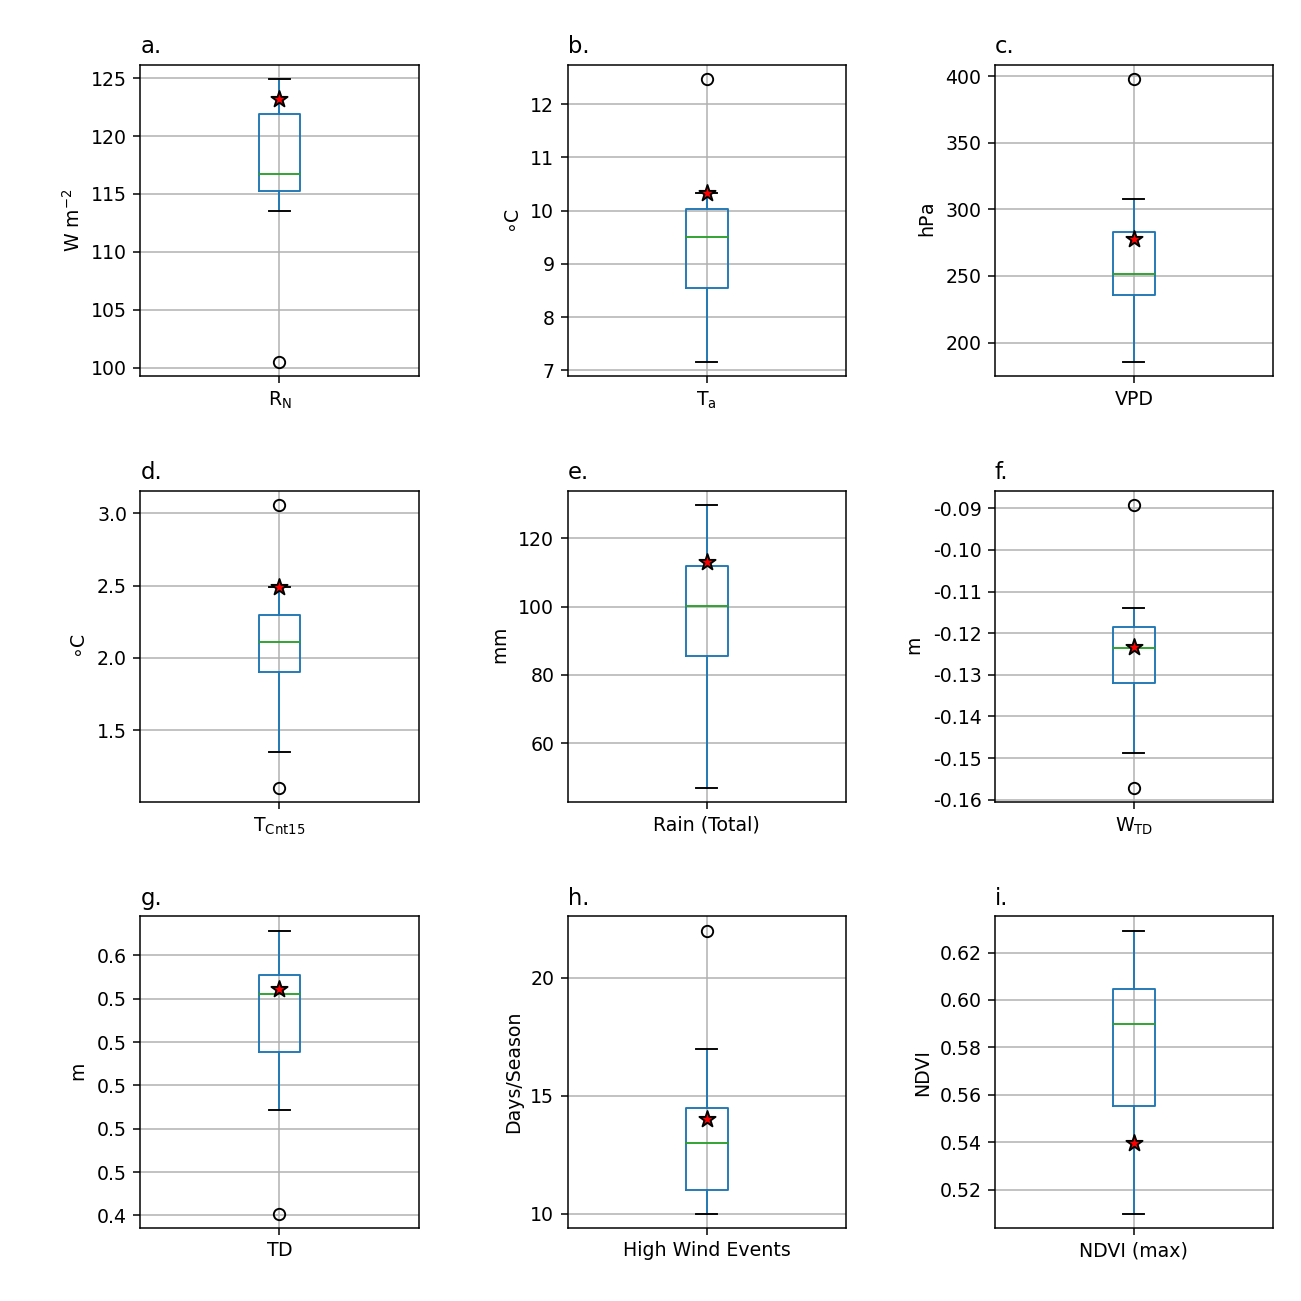

[Text(1, 0, 'NR_Wm2_Avg')]
[Text(1, 0, 'Air_Temp')]
[Text(1, 0, 'VPD')]
[Text(1, 0, 'Temp_15_1')]
[Text(1, 0, 'Rainfall')]
[Text(1, 0, 'Table_1')]
[Text(1, 0, 'Active_Layer_1')]
[Text(1, 0, 'High_Wind')]
[Text(1, 0, 'NDVI')]


In [260]:
from matplotlib.ticker import FormatStrFormatter

print(Y.describe().round(2))

Y['Agg'] = 1
fig,ax = plt.subplots(3,3,figsize=(7,7))

Row1 = ['NR_Wm2_Avg','Air_Temp','VPD']
Row2 = ['Temp_15_1','Rainfall','Table_1']
Row3 = ['Active_Layer_1','High_Wind','NDVI']
# for 
Keys = {'NR_Wm2_Avg':{
                    'Name':'$R_N$',
                    'Label':'W $m^{-2}$'
                   },
        'PPFD_Avg':{
                    'Name':'$PPFD$',
                    'Label':'$\mu mol m^{-2} s^{-1}$'
                   },
        'Air_Temp':{
                    'Name':'$T_{a}$',
                    'Label':'$\circ C$'
                   },
        'Temp_5_1':{
                    'Name':'$T_{Cnt5}$',
                    'Label':'$\circ C$'
                   },
        'Temp_15_1':{
                    'Name':'$T_{Cnt15}$',
                     'Label':'$\circ C$'
                    },
        'VPD':{
                    'Name':'VPD',
                     'Label':'$hPa$'
                    },
        'Active_Layer_1':{
                    'Name':'$TD$',
                     'Label':'$m$'
                    },
        'Table_1':{
                    'Name':'$W_{TD}$',
                     'Label':'$m$'
                    },
        'u*':{
                    'Name':'u*',
                     'Label':'$m s^{-1}$'
                    },
        'wind_speed':{
                    'Name':'U',
                     'Label':'$m s^{-1}$'
                    },
        'High_Wind':{
                    'Name':'High Wind Events',
                    'Label':'Days/Season'
                    },
        'Rainfall':{
                    'Name':'Rain (Total)',
                     'Label':'$mm$'
                    },
        'NDVI':{
                    'Name':'NDVI (max)',
                     'Label':'NDVI'
                    },
        'NDWI':{
                    'Name':'NDWI (max)',
                     'Label':'NDVI'
                    },
       }

Titles = ['a.','b.','c.',
          'd.','e.','f.',
          'g.','h.','i.']
for i, v in enumerate(Row1):
    Y[[v]].boxplot(ax=ax[0,i])
    print(ax[0,i].get_xticklabels())
    ax[0,i].set_ylabel(Keys[v]['Label'])
    ax[0,i].set_xticklabels([Keys[v]['Name']])
    ax[0,i].set_title(Titles[i],loc='left')
    ax[0,i].scatter([1],Rank.loc[Rank['Driver']==v,'Value'].values[0],marker='*',s=80,color='r',edgecolor='k',zorder=3)
    ax[0,i].set_axisbelow(True)
    
for i, v in enumerate(Row2):
    Y[[v]].boxplot(ax=ax[1,i])
    print(ax[1,i].get_xticklabels())
    ax[1,i].set_ylabel(Keys[v]['Label'])
    ax[1,i].set_xticklabels([Keys[v]['Name']])
    ax[1,i].set_title(Titles[i+3],loc='left')
    ax[1,i].scatter([1],Rank.loc[Rank['Driver']==v,'Value'].values[0],marker='*',s=80,color='r',edgecolor='k',zorder=3)
    ax[1,i].set_axisbelow(True)
    if i == 0:
        ax[1,i].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    if i == 2:
        ax[1,i].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
for i, v in enumerate(Row3):
    Y[[v]].boxplot(ax=ax[2,i])
    print(ax[2,i].get_xticklabels())
    ax[2,i].set_ylabel(Keys[v]['Label'])
    ax[2,i].set_xticklabels([Keys[v]['Name']])
    ax[2,i].set_title(Titles[i+6],loc='left')
    ax[2,i].scatter([1],Rank.loc[Rank['Driver']==v,'Value'].values[0],marker='*',s=80,color='r',edgecolor='k',zorder=3)
    ax[2,i].set_axisbelow(True)
    if i == 1:
        ax[2,i].set_yticks([10,15,20])#yaxis.set_major_formatter(FormatStrFormatter('%i'))
    if i == 0:
        ax[2,i].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    if i == 2:
        ax[2,i].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.tight_layout()

plt.savefig(G_Drive+'PhD_Thesis\\Chapter3_Figs/AnnualDrivers.png',dpi=600)

<IPython.core.display.Javascript object>


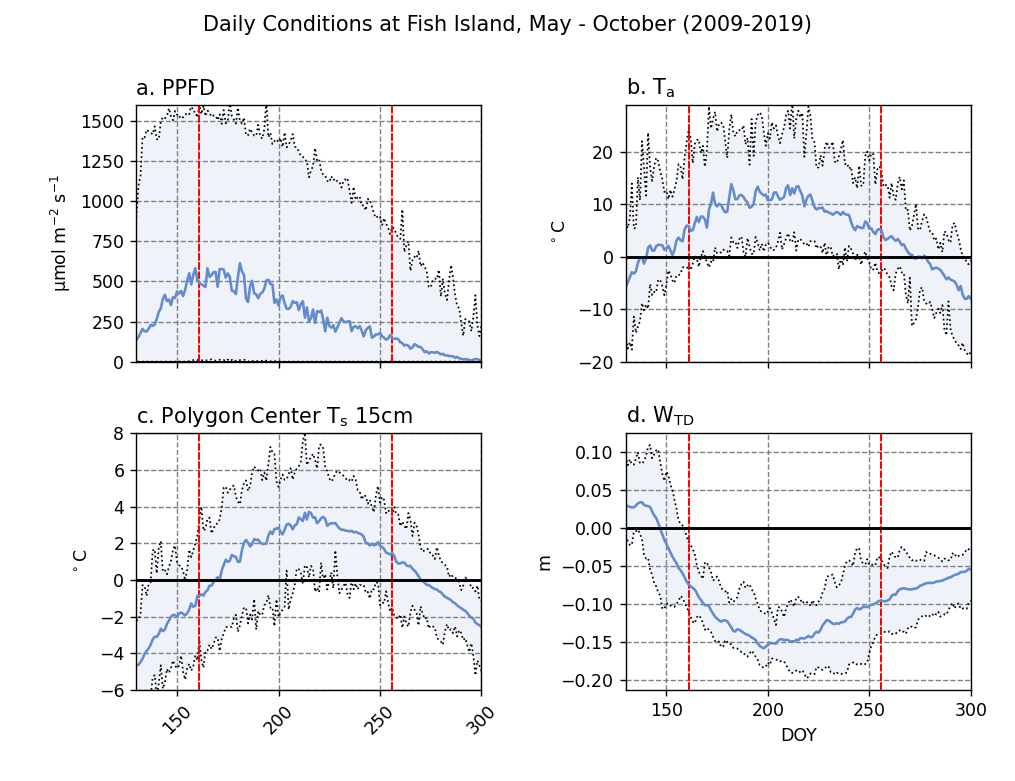

In [391]:
### print((Data_y[['Air_Temp','Rainfall','NR_Wm2_Avg','Temp_5_1','Temp_5_2','Temp_15_1','Temp_15_2','Table_1','Active_Layer_1']].corr()**2).round(2))#,'NR_Wm2_Avg']])
Data['MM-DD'] = Data.index.strftime('%m-%d')
DataT = Data.loc[((Data.index.month>=4)&(Data.index.month<=11)
                  &
                 (Data.index.year>=2009)&(Data.index.year<=2019)
                 )]

Data_d = DataT.groupby('DOY').mean()
Data_d['Rainfall'] = DataT.groupby('DOY').sum()['Rainfall']
Data_d_mx = DataT.groupby('DOY').max()
Data_d_mn = DataT.groupby('DOY').min()
fig,axes = plt.subplots(2,2,figsize=(6.5,5),sharex=True)#(18.2*cm_2_in, 13*cm_2_in),sharex=True)

ecolor='k'

# ax = axes[1,1]
ax = axes[0,0]
ax.plot(Data_d['Temp_5_1']*0,color='k')
# ax.plot(GS['Temp_15_1'],color='r')
ax.plot(Data_d['PPFD_Avg'],color='#648ccc')
ax.fill_between(Data_d.index,Data_d_mn['PPFD_Avg'],Data_d_mx['PPFD_Avg'],
                facecolor='#648ccc1A',edgecolor=ecolor,linestyle=':')
ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed')
ax.set_title('a. PPFD',loc='left')
ax.set_ylabel('$\mu mol$ $m^{-2}$ $s^{-1}$')
ax.set_ylim(0,1600)

ax = axes[0,1]
ax.plot(Data_d['Temp_5_1']*0,color='k')
# ax.plot(GS['Air_Temp'],color='r')
ax.plot(Data_d['Air_Temp'],color='#648ccc')
ax.fill_between(Data_d.index,Data_d_mn['Air_Temp'],Data_d_mx['Air_Temp'],
                facecolor='#648ccc1A',edgecolor=ecolor,linestyle=':')
ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed')
ax.set_title('b. $T_a$',loc='left')
ax.set_ylabel('$^\circ$C')
ax.set_ylim(-20,29)

ax = axes[1,0]
ax.plot(Data_d['Temp_5_1']*0,color='k')
# ax.plot(GS['Temp_5_1'],color='r')
ax.plot(Data_d['Temp_15_1'],color='#648ccc')
ax.fill_between(Data_d.index,Data_d_mn['Temp_15_1'],Data_d_mx['Temp_15_1'],
                facecolor='#648ccc1A',edgecolor=ecolor,linestyle=':')
ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed')
ax.set_title('c. Polygon Center $T_s$ 15cm',loc='left')
ax.set_ylabel('$^\circ$C')
ax.set_ylim(-6,8)

for label in ax.get_xticklabels():
    label.set_ha("center")
    label.set_rotation(45)

# ax = axes[2,0]
ax = axes[1,1]
ax.plot(Data_d['Temp_5_1']*0,color='k')
# ax.plot(GS['Table_1'],color='r')
ax.plot(Data_d['Table_1'],color='#648ccc')
ax.fill_between(Data_d.index,Data_d_mn['Table_1'],Data_d_mx['Table_1'],
                facecolor='#648ccc1A',edgecolor=ecolor,linestyle=':')
ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed')
ax.set_title('d. $W_{TD}$',loc='left')
ax.set_ylabel('m')
ax.set_xlabel('DOY')


for label in ax.get_xticklabels():
    label.set_ha("center")
    
for aa in axes:
    for a2 in aa: 
        a2.plot(Data_d['Air_Temp']*0,color='k')
        a2.axvspan(161,161,facecolor=[.97,.97,.97,.0],
                  edgecolor='r',linestyle='--')
        a2.axvspan(256,256,facecolor=[.97,.97,.97,.0],
                  edgecolor='r',linestyle='--')
# ax.set_xticks(P[1::2])
ax.set_xlim(130,300)

plt.suptitle('Daily Conditions at Fish Island, May - October (2009-2019)')

plt.tight_layout()

# plt.savefig('G:\\My Drive\\PhD_Thesis\\Chapter3_FiData/Drivers.jpg',dpi=600)
plt.savefig(G_Drive+'PhD_Thesis/Chapter3_Figs/'+'DailyValues.png',dpi = 600)

In [262]:
print(Data.loc[Data['Study_Season']==1].resample('Y').min()['DOY'])

2009-12-31   161.0000
2010-12-31   153.0000
2011-12-31   153.0000
2012-12-31   154.0000
2013-12-31   161.0000
2014-12-31   156.0000
2015-12-31   151.0000
2016-12-31   148.0000
2017-12-31   151.0000
2018-12-31   161.0000
2019-12-31   146.0000
Freq: A-DEC, Name: DOY, dtype: float64


In [1568]:
def Rsmp(EC_Data):  
    kwargs = {'closed':'right','label':'left'}
    
    EC_Data['dmx']= EC_Data.index.dayofyear*1000+EC_Data.index.hour+0

    EC_Data['DMX'] = EC_Data['dmx'].shift(1)
    
    EC_Data['TS'] = EC_Data.index.copy()
#     print(EC_Data['TS'])
    
    EC_Data_r=EC_Data.resample('h',**kwargs).mean()
    EC_Data_r['TS1']=EC_Data.resample('h',**kwargs).first()['TS']
    EC_Data_r['TS2']=EC_Data.resample('h',**kwargs).last()['TS']
    EC_Data_r['C']=EC_Data.resample('h',**kwargs).count()['fco2']
    
    EC_Data_r['Rain_mm_Tot']=EC_Data.resample('h',**kwargs).sum()['Rain_mm_Tot']
    

    EC_Data_r = EC_Data_r.drop(['Wind_Direction', 'Wind_Speed'],axis=1)



    EC_Data_r_mask = EC_Data.resample('h',**kwargs).count()[['fco2','fch4']]
    EC_Data_r_mask['DMX'] = EC_Data.resample('h',**kwargs).min()['DMX']

    EC_Data_r_mask.loc[EC_Data_r_mask['fco2']<2,'fco2']=np.nan
    EC_Data_r_mask.loc[EC_Data_r_mask['fch4']<2,'fch4']=np.nan

    EC_Data_r_mask[['fco2','fch4']]/=2
    EC_Data_r['fco2']*=EC_Data_r_mask['fco2']
    EC_Data_r['fch4']*=EC_Data_r_mask['fch4']
#     print(EC_Data_r['C'])
    return(EC_Data_r)
def VL(TB,key,Comp,model):
    DNA = TB[key].dropna()
    
    print(DNA.index[0],DNA.index[-1])
    Comp['Species'].append(key[-1])
    Comp['Model'].append(model)
    Comp['R2'].append(metrics.r2_score(DNA[key[0]],DNA[key[-1]]))
    Comp['RMSE'].append(metrics.mean_squared_error(DNA[key[0]],DNA[key[-1]])**.5)
    Comp['Flux'].append(DNA[key[-1]].mean())
    Comp['Std'].append(
        DNA[key[-1]].std()
    )
    Comp['N'].append(DNA[key[-1]].count())
    Comp['Estimate'].append(DNA[key[0]].mean())
    Comp['Estimate_CI'].append(DNA[key[1]].mean())

In [1576]:
Dpath = G_Drive+'FishIsland_Outputs/Benchmark_30m.csv'
Benchmark_30 = pd.read_csv(Dpath,index_col=['datetime'],parse_dates=['datetime'])
Benchmark_30.index = Benchmark_30.index.tz_localize(None)
Benchmark_30['DH'] = Benchmark_30.index.dayofyear*1e4+Benchmark_30.index.hour
Data['DH'] = Data.index.dayofyear*1e4+Data.index.hour
Benchmark_30 = Benchmark_30.drop(columns=['datetime.1'])
Benchmark_H = Rsmp(Benchmark_30)
# Benchmark_30[['co2_flux','fco2']].count()

print(Benchmark_30['fco2'].count())
print(Benchmark_H['fco2'].count())
print(Data['fco2'].count())
Val_Set_co2 = Benchmark_H[['fco2','TS1','TS2']].dropna()
Benchmark_30.loc[((Benchmark_30.index.isin(Val_Set_co2['TS1']))|
                   (Benchmark_30.index.isin(Val_Set_co2['TS2']))),'keep']=1
Benchmark_30.loc[((Benchmark_30['keep']==1)&(Benchmark_30['fco2'].isnull())),['fco2','co2_flux']]
print(Benchmark_30.loc[(Benchmark_30['keep']==1),['fco2','co2_flux']].count()/2)
Benchmark_30.loc[(Benchmark_30['keep']!=1),'fco2']=np.nan
print(Benchmark_30[['fco2','co2_flux']].count()/2)

print(Benchmark_30['fch4'].count())
print(Benchmark_H['fch4'].count())
print(Data['fch4'].count())
Val_Set_ch4 = Benchmark_H[['fch4','TS1','TS2']].dropna()
Benchmark_30.loc[((Benchmark_30.index.isin(Val_Set_ch4['TS1']))|
                   (Benchmark_30.index.isin(Val_Set_ch4['TS2']))),'keep2']=1
Benchmark_30.loc[((Benchmark_30['keep2']==1)&(Benchmark_30['fch4'].isnull())),['fch4','ch4_flux']]
print(Benchmark_30.loc[(Benchmark_30['keep2']==1),['fch4','ch4_flux']].count()/2)
Benchmark_30.loc[(Benchmark_30['keep2']!=1),'fch4']=np.nan
print(Benchmark_30[['fch4','ch4_flux']].count()/2)


2501
1164
1164
fco2       1164.0000
co2_flux   1164.0000
dtype: float64
fco2       1164.0000
co2_flux   1250.5000
dtype: float64
1441
653
653
fch4       653.0000
ch4_flux   653.0000
dtype: float64
fch4       653.0000
ch4_flux   720.5000
dtype: float64


In [1577]:
# Benchmark_H['NEE_est','NEE_est_CI'].mean()
# Benchmark_H['NEE_est','NEE_est_CI'].mean()

In [1578]:

Comp = {
    'Species':[],
    'Model':[],
    'N':[],
    'Flux':[],
    'Std':[],
    'Estimate':[],
    'Estimate_CI':[],
    'R2':[],
    'RMSE':[],
    
}


Data.loc[Data.index.isin(Benchmark_H.index),'co2_flux'] = Data.loc[Data.index.isin(Benchmark_H.index),'co2_flux'].fillna(Benchmark_H['NEE_est'])

Benchmark_H['co2_flux'] = Benchmark_H['co2_flux'].fillna(Benchmark_H['NEE_est'])

Data.loc[Data.index.isin(Benchmark_H.index),'ch4_flux'] = Data.loc[Data.index.isin(Benchmark_H.index),'ch4_flux'].fillna(Benchmark_H['NEE_est'])

Benchmark_H['ch4_flux'] = Benchmark_H['ch4_flux'].fillna(Benchmark_H['NEE_est'])

co2 = ['NEE_est','NEE_est_CI','fco2']
ch4 = ['FCH4_FP_est','FCH4_FP_est_CI','fch4']
fch4 = ['NME_est','NME_est_CI','fch4']
VL(Benchmark_30,co2,Comp,'Skeeter 30')
VL(Benchmark_H,co2,Comp,'Skeeter h')
VL(Data,co2,Comp,'Here')
VL(Benchmark_30,fch4,Comp,'Skeeter 30')
VL(Benchmark_H,fch4,Comp,'Skeeter h')
VL(Data,ch4,Comp,'Here')
Comp = pd.DataFrame(Comp)
Comp.set_index('Species').T
# # print(Benchmark_h.index)
# # print(Benchmark_30.index)

2017-06-23 00:30:00 2017-09-13 12:00:00
2017-06-23 00:00:00 2017-09-13 11:00:00
2017-06-23 00:00:00 2017-09-13 11:00:00
2017-06-23 00:30:00 2017-09-13 12:00:00
2017-06-23 00:00:00 2017-09-13 11:00:00
2017-06-23 00:00:00 2017-09-13 11:00:00


Species,fco2,fco2,fco2,fch4,fch4,fch4
Model,Skeeter 30,Skeeter h,Here,Skeeter 30,Skeeter h,Here
N,2328,1164,1164,1306,653,653
Flux,-0.8923,-0.8923,-0.8923,33.7513,33.7513,33.7513
Std,1.4942,1.4806,1.4806,12.5856,11.9906,11.9906
Estimate,-0.8916,-0.8916,-0.8983,33.8621,33.8621,33.5112
Estimate_CI,0.2394,0.2394,0.2440,3.2473,3.2473,3.2273
R2,0.9484,0.9600,0.9803,0.7449,0.8313,0.9374
RMSE,0.3282,0.2870,0.2020,5.5857,4.5018,2.7785


<IPython.core.display.Javascript object>


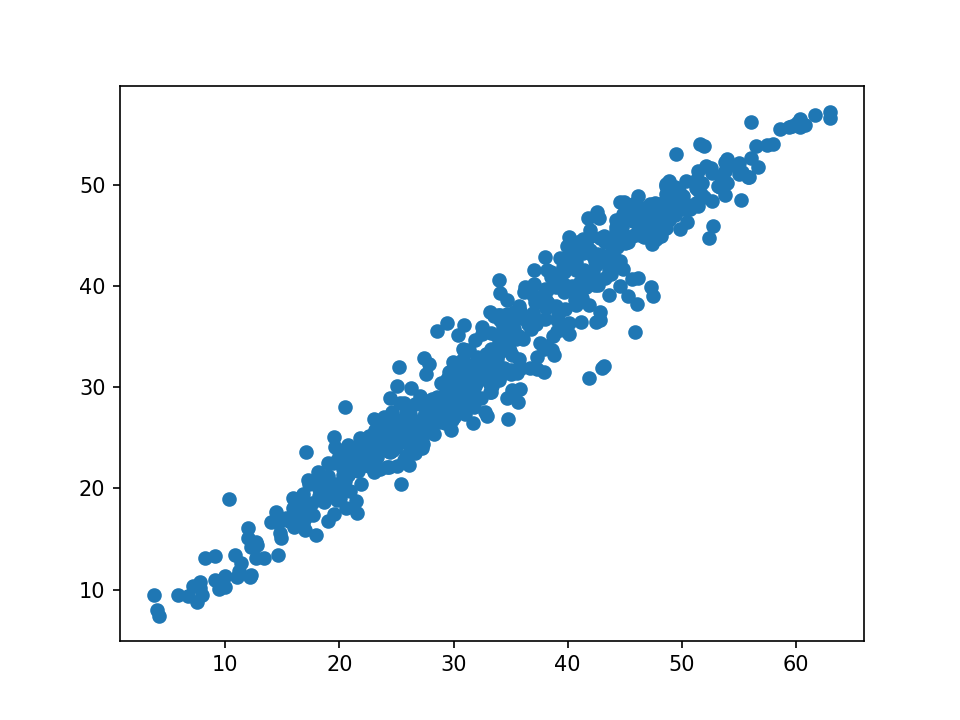

0.9462241757276728


In [1580]:
# Sub = Benchmark_H[['fco2','fch4','NEE_est','NME_est']].copy()
# Sub = Sub.join(Data[['NEE_est','NME_est']],rsuffix='_FDTS')

# print(metrics.r2_score(Sub['NEE_est'],Sub['NEE_est_FDTS']))
# print(metrics.mean_squared_error(Sub['NEE_est'],Sub['NEE_est_FDTS'])**.5)
# print(Data.loc[Data.index.isin(Benchmark_H.index),['NEE_est','NEE_est_CI','NME_est','NME_est_CI']].mean())
# print(Benchmark_H[['NEE_est','NEE_est_CI','NME_est','NME_est_CI']].mean())
DNA = Data[['fch4','FCH4_FP_est']].dropna()
plt.figure()
plt.scatter(DNA['fch4'],DNA['FCH4_FP_est'])

print(metrics.r2_score(DNA['fch4'],DNA['FCH4_FP_est']))

# Validation

In [380]:

Data['GPP_est']=Data['ER_est'] - Data['NEE_est']
Data['GPP_est_CI']=Data['ER_est_CI'] + Data['NEE_est_CI']
Data[['GPP_est','GPP_est_CI']]*=mult['fco2']
print(Data.loc[((Data['Study_Year']==1)),
               ['GPP_d','GPP_est','NEE_est','ER_est']].resample('Y').sum().corr(method='spearman'))



         GPP_d  GPP_est  NEE_est  ER_est
GPP_d   1.0000   0.5364   0.2636  0.3273
GPP_est 0.5364   1.0000   0.6818  0.8818
NEE_est 0.2636   0.6818   1.0000  0.8727
ER_est  0.3273   0.8818   0.8727  1.0000


       NEE_est   GPP_8d   ER_est
count 132.0000 132.0000 132.0000
mean   -0.5588 122.5979   1.8926
std     0.5499  80.8943   1.2381
min    -1.5795  12.6370   0.6412
25%    -0.9642  53.1739   0.8596
50%    -0.6099 109.7328   1.4629
75%    -0.1732 176.5499   2.6528
max     1.3731 392.3798   6.0463
            DOY  Daytime
Date                    
2017-06-10  161 192.0000
2017-06-18  169 192.0000
2017-06-26  177 192.0000
2017-07-04  185 192.0000
2017-07-12  193 192.0000
2017-07-20  201 187.0000
2017-07-28  209 166.0000
2017-08-05  217 153.0000
2017-08-13  225 143.0000
2017-08-21  233 129.0000
2017-08-29  241 122.0000
2017-09-06  249 112.0000
GPP_est_c       77
GPP_est_c_CI    77
GPP_8d          77
dtype: int64
GPP_est_c       12.1630
GPP_est_c_CI     8.9072
GPP_8d         113.6962
dtype: float64
                            OLS Regression Results                            
Dep. Variable:              GPP_est_c   R-squared:                       0.651
Model:                            OLS 

<IPython.core.display.Javascript object>


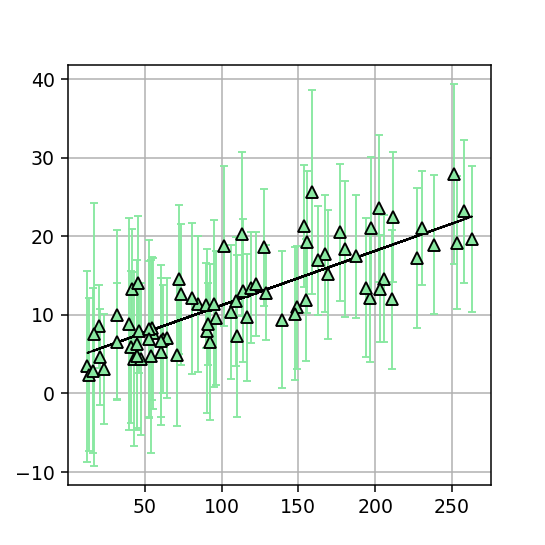

In [335]:
print(GPP8[['NEE_est','GPP_8d','ER_est']].describe())

GPP8['GPP_est']=GPP8['ER_est'] - GPP8['NEE_est']

GPP8['DOY']=GPP8.index.dayofyear

print(GPP8.loc[GPP8.index.year==2017,['DOY','Daytime']])

Step = GPP8.copy()
Step['NEE_est_c']=Step['NEE_est']*mult['fco2']*24
Step['NEE_est_c_CI']=Step['NEE_est_CI']*mult['fco2']*24

Step['GPP_est']=Step['ER_est'] - Step['NEE_est']
Step['GPP_est_CI']=Step['ER_est_CI']+Step['NEE_est_CI']
Step['GPP_est_c']=Step['GPP_est']*mult['fco2']*24*8
Step['GPP_est_c_CI']=Step['GPP_est_CI']*mult['fco2']*24*8

# Step['GPP_d']=Step['GPP_8d'].copy()/24
Step['GPP_est_U'] = Step['GPP_est_c']+Step['GPP_est_c_CI']

DNA = Step.loc[Step['Daytime'].index.dayofyear>=201,['GPP_est_c','GPP_est_c_CI','GPP_8d']].copy()
# DNA = Step.loc[Step['Daytime'].index.dayofyear>=20,['GPP_est_c','GPP_est_c_CI','GPP_d']].copy()
print(DNA.count())

print(DNA.mean())
X2 = sm.add_constant(DNA['GPP_8d'], has_constant='add')
est = sm.OLS(DNA['GPP_est_c'], X2)
est = est.fit()
rF = est.rsquared_adj
print(est.summary())
print(DNA.corr())

fig,ax=plt.subplots(figsize=(4,4))
ax.errorbar(DNA['GPP_8d'],DNA['GPP_est_c'],yerr=DNA['GPP_est_c_CI'],lw=1,elinewidth=1,capsize=2,
                   color='#89e8a1',markeredgecolor='k',marker='^',ls='None')
# ax.plot()

ax.plot(DNA['GPP_8d'],est.predict(X2),color='k',linewidth=1,linestyle='--',
        label='Average Fit $r^2$ = '+(str(np.round(rF,2))),
            zorder=2)
ax.grid()
plt.savefig(G_Drive+'PhD_Thesis\\Chapter3_Figs/Assessment.png',dpi=600)

             GPP_est_c GPP_est_c_CI  GPP_8d
GPP_est_c       1.0000       0.1600  0.1400
GPP_est_c_CI    0.1600       1.0000 -0.6700
GPP_8d          0.1400      -0.6700  1.0000


<IPython.core.display.Javascript object>


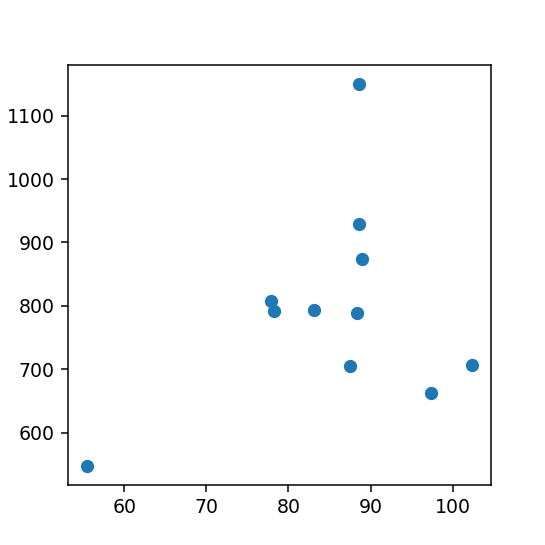

In [352]:
Yearly = DNA.resample('Y').sum()
r,p = r_pvalues(Yearly,method='spearman',L=2)
# r[p>.1]=np.nan
print(r)
plt.figure(figsize=(4,4))
plt.scatter(Yearly['GPP_est_c'],Yearly['GPP_8d'])
# print(DNA.loc[DNA.index.year==y])
# for y in range(2009,2020):
#     Year = DNA.loc[DNA.index.year==y].copy()
#     print(y,(Year[['GPP_est_c','GPP_8d']].corr()**2)['GPP_8d']['GPP_est_c'].round(2))

In [239]:
# Step = GPP8.copy()
# Step = Step.loc[Step['Daytime']<192].copy()
# print(Step['Daytime'])
# Step['NEE_est_c']=Step['NEE_est']*mult['fco2']*24
# Step['NEE_est_c_CI']=Step['NEE_est_CI']*mult['fco2']*24

# Step['GPP_est']=Step['ER_est'] - Step['NEE_est']
# Step['GPP_est_CI']=Step['NEE_est_CI']+Step['ER_est_CI']
# Step['GPP_est_c']=Step['GPP_est']*mult['fco2']*24
# Step['GPP_est_c_CI']=Step['GPP_est_CI']*mult['fco2']*24

# Step['GPP_d']=Step['GPP_8d']/8

# X = ['GPP_d']
# y = 'GPP_est_c'
# DNAF=Step[X+[y]].dropna()
# X2F = sm.add_constant(DNAF[X], has_constant='add')
# est = sm.OLS(DNAF[y], X2F)
# estF = est.fit()
# print(estF.summary())

# r,p = r_pvalues(DNAF,method = 'spearman')
# r[p>0.05]=np.nan
# rF = np.round(estF.rsquared_adj,2)

# m = estF.params
# m.name='mean'
# Full = estF.conf_int().T.diff().T.join(m)[[1,'mean']]
# Full['R'] = estF.rsquared_adj

# fig,ax=plt.subplots(2,figsize=(6.5,6.5),sharey=True)

# OL = []
# OC = ['r','b','orange','y','aqua','pink','cyan','green','tan']
# i = 0

# for S in range(2009,2020):
#     DNA=Step.loc[Step.index.year==S,X+[y,y+'_CI']].dropna()
#     X2 = sm.add_constant(DNA[X], has_constant='add')
#     est = sm.OLS(DNA[y], X2)
#     est = est.fit()
    
#     if est.rsquared_adj >= rF:
#         ax[0].scatter(DNA[X[0]],DNA[y],#yerr=DNA[y+'_CI'],
#                        marker='o',color='white',
#                        edgecolor='k',zorder=-1,
#                      )
#     else:
#         OL.append([DNA,est.predict(X2),S,np.round(est.rsquared_adj,2)])
#     print(S,' r2: ',np.round(est.rsquared_adj,2))
#     m = est.params
#     m.name='mean'
#     Year = est.conf_int().T.diff().T.join(m)[[1,'mean']]
#     Year['R'] = est.rsquared_adj
#     Year['Set']=str(S)
    
#     Full = Full.append(Year)
    
# for ol in OL:
#     print(i)
#     ax[0].errorbar(ol[0][X[0]],ol[0][y],yerr=ol[0][y+'_CI'],marker='^',ls='None',elinewidth=1,capsize=2,
#                 color=OC[i],markeredgecolor='k',zorder=3,
#             label=str(ol[2])+': $r^2$ = '+(str(ol[3])))
#     i += 1
    
    
# ax[0].scatter(DNA[X[0]],DNA[y],#yerr=DNA[y+'_CI'],
#                marker='o',color='white',
#                edgecolor='k',zorder=-1,label='Non-Outliers'#+str(np.round(rF,2))
# #                       ls='None',ecolor='grey'
#              )

# ax[0].plot(DNAF[X],estF.predict(X2F),color='k',linewidth=1,linestyle='--',
#         label='Average Fit $r^2$ = '+(str(np.round(rF,2))),
#             zorder=2)

# ax[0].legend()
# ax[0].grid()
# ax[0].set_ylabel('8-Day mean NEE g CO$_2$-C m$^{-2}$ d$^{-1}$')
# ax[0].set_xlabel('8-Day MODIS GPP g CO$_2$-C m$^{-2}$ d$^{-1}$')
# ax[0].set_title('a.',loc='left')

# ax2 = ax[1].twinx()

# Step['Year']=Step.index.year
# VS2 = Step.set_index(Step.index.dayofyear)
# for y,c in zip([2009,2013,2018],OC):
#     Sel = VS2.loc[VS2['Year']==y].copy()
#     Sel[['NEE_est_c','NEE_est_c_CI']]**24
#     ax[1].errorbar(Sel.index,Sel['NEE_est_c'],lw=1,label=str(y),
#                    color=c,markeredgecolor='k',marker='^')
#     ax2.errorbar(Sel.index,Sel['GPP_d'],ls='--',lw=1,
#                    color=c,markeredgecolor='k',marker='^')

# Other = Step.loc[((Step['Year']!=2009)&(Step['Year']!=2013)&(Step['Year']!=2018))].copy()


# VSD = Other.groupby(Other.index.dayofyear).mean()
# ax[1].errorbar(VSD.index,VSD['NEE_est'],lw=1,
#                marker='o',mfc='white',
#                color='k',markeredgecolor='k',zorder=-1,ecolor='k',label='No-Outliers')

# ax2.errorbar(VSD.index,VSD['GPP_d'],ls='--',lw=1,
#                marker='o',mfc='white',color='k',markeredgecolor='k',zorder=-1,ecolor='k')

# ax[1].grid()

# ax[1].set_ylabel('8-Day mean NEE g CO$_2$-C m$^{-2}$ d$^{-1}$')
# ax2.set_ylabel('8-Day MODIS GPP g CO$_2$-C m$^{-2}$ d$^{-1}$')
# ax[1].set_xlabel('Day of Year')
# ax[1].set_title('b.',loc='left')

# ax[1].legend()

# plt.tight_layout()
# plt.savefig(G_Drive+'PhD_Thesis\\Chapter3_Figs/Assessment.png',dpi=600)


In [240]:
# # fig,ax=plt.subplots()
# # GPP8[['NDVI_FI_LCP','NEE_est']].corr()**2
# Step['DOY']=Step.index.dayofyear
# print(Step.loc[Step['NEE_est']==Step['NEE_est'].max(),['NEE_est_c','NEE_est_c_CI','GPP_d']])
# print()
# D = 217
# print(Step.loc[Step['DOY']==D,['NEE_est_c','NEE_est_c_CI','GPP_d']].describe())
# print()



# (Step.loc[Step['DOY']==D,['NEE_est_c','NEE_est_c_CI',
#          'GPP_d']]-Step.loc[Step['DOY']==D,['NEE_est_c','NEE_est_c_CI',
#             'GPP_d']].mean())/Step.loc[Step['DOY']==D,['NEE_est_c','NEE_est_c_CI','GPP_d']].std()


# VSD = Step.groupby(Step.index.dayofyear).mean()
# print()
# X = ['GPP_8d']
# y='NEE_est_c'
# DNAF=VSD[X+[y]].dropna()
# X2F = sm.add_constant(DNAF[X], has_constant='add')
# est = sm.OLS(DNAF[y], X2F)
# estF = est.fit()
# print(estF.summary())
# print(Full.dropna()['R'].describe())

In [42]:
# Data['Year']=Data.index.year
# VS = Data.loc[Data['Study_Year']==1].groupby('GPPK').mean()[['NEE_est_c','NEE_est_c_CI','NEE_est','ER_est',
#                                                               'GPP_8d','Active_Layer_1','Air_Temp','GPP_d','PSN_8d',
#                                                             'fco2','NDVI_FI_LCP']]

# print(VS.loc[VS['NEE_est']])
# # VS['Date'] = Data.loc[Data['Season_Class']=='Mid_Season'].groupby('GPPK').first()['Date']
# # VS['Study_Year'] = Data.loc[Data['Season_Class']=='Mid_Season'].groupby('GPPK').sum()['Study_Year']
# # VS['ER'] = Data.loc[Data['Season_Class']=='Mid_Season'].groupby('GPPK').max()['NEE_est_c']*24
# # # VS
# # VS = VS[VS['Study_Year']>=8*24-1]
# # VS = VS.set_index(pd.DatetimeIndex(VS['Date']))
# # VS['ER_est'] *= mult['fco2']*24

# # VS['NEE_est_c']*=24
# # VS['GPP_d']*=24
# # VS['GPP_est'] = (1.6+.9) - VS['NEE_est_c']

# # VS['GPP_8d']/=8
# # VS['PSN_8d']/=8

# # # print(VS['GPP_8d'].std()/VS['GPP_8d'].count()**.5*stats.t.ppf(0.975,VS['GPP_8d'].count()))


# # print()
# # print('Over')
# # print(VS['GPP_8d'].mean()/VS['GPP_est'].mean())
# # # print(VS.resample('Y').first()['NEE_est'])

# # # Data.loc
# # VS['DOY'] = VS.index.dayofyear
# # VS['Year'] = VS.index.year


In [43]:
# fig,ax=plt.subplots(1,2)
# VS[['NEE_est']].boxplot(ax=ax[0])
# # plt.figure()
# VS[['GPP_8d']].boxplot(ax=ax[1])
# print(VS[['NEE_est','GPP_8d']].describe())

# print(VS.loc[VS.index.year==2018].index.dayofyear)

# print(Data.loc[((Data.index.year==2018)&(Data.index.dayofyear<169)),['NEE_est','NEE_est_CI']].mean())

In [44]:

# X = ['NDVI_FI_LCP']+['VPD']+['Table_1']

# Scale = GPP8.copy()

# Scale['const']=1

# v = 'NEE_est'
# DNA = Scale[[v]+X].dropna()
# # print(DNA.corr()**2)
# # DNA.corr()**2
# X2 = sm.add_constant(DNA[X], has_constant='add')
# est = sm.OLS(DNA[v], X2)
# est = est.fit()
# print(est.summary())

# Scale['est']=est.predict(Scale[['const']+X])

# plt.figure(figsize=(4,4))
# plt.scatter(Scale[v],Scale['est'])


# print(Scale.loc[((Scale.index.year<=2019)&(Scale.index.year>=2009))].resample('Y').mean()[['est','NEE_est']])
# # Scale['NEE']

# Scale.loc[((Scale.index.year>2019)|(Scale.index.year<2009)),['est','NEE_est']]=np.nan


# # plt.figure(figsize=(4,4))
# # # plt.figure()
# # plt.bar(Scale.resample('Y').mean().index.year,Scale.resample('Y').mean()['est'],
# #             yerr=(Scale.resample('Y').std()['est']/(Scale.resample('Y').count()['est']**.5))*stats.t.ppf(1-0.025,
# #                                   Scale.resample('Y').count()['est']),
# #        edgecolor='k',width = .4)
# # plt.bar(Scale.resample('Y').mean().index.year+.45,Scale.resample('Y').mean()['NEE_est'],
# #             yerr=(Scale.resample('Y').std()['est']/(Scale.resample('Y').count()['NEE_est']**.5))*stats.t.ppf(1-0.025,
# #                                   Scale.resample('Y').count()['NEE_est']),
# #        edgecolor='k',width = .4)
# # # print(yerr)

In [45]:
# plt.figure()
# # Data.loc[((Data.index.year==2018)&((Data.index.month==5)|(Data.index.month==6))),'NDWI_FI_LCP'].resample('D').mean().plot()
# Data.loc[((Data.index.year==2019)&((Data.index.month==5)|(Data.index.month==6))),'NDWI_FI_LCP'].resample('D').mean().plot()
# # July[['NEE_est','Temp_5_1']].corr()
# plt.grid()

In [46]:
# # P = Data.loc[Data.index.year==2015,'Rainfall'].cumsum()
# # plt.figure(figsize=(4,4))
# # plt.plot(P.index,P)


# # Data.resample('D').sum()['Rainfall'].sort_values(ascending=False)[:25]

# Data.loc[Data['Rainfall']>0].resample('Y').count()['Rainfall'].sort_values()